IDEAT: Vix takas? Joku momentum indikaattori? Sentimentti?




##Model settings

In [404]:
use_regime_split = False

#Default models
RF = True # perus random forest
GB = False # perus gradient boost
Hybrid = False

#Looping models
RF_feature_seek = False # random forest all combinations
seek_all = False
gb_loop = False

#DATA
FF5 = False
FF5_long = True
MSCI = False

local = False #ajetaanko colab vai oma kone




In [405]:
# Identify active model flags
active_modes = [name for name, flag in zip(
    ['RF', 'GB', 'RF_feature_seek', 'Hybrid', 'seek_all', 'gb_loop'],
    [RF, GB, RF_feature_seek, Hybrid, seek_all, gb_loop]
) if flag]

if active_modes:
    print("✅ Active model modes:", ", ".join(active_modes))
else:
    print("⚠️ No active model mode selected.")

# Check dataset toggles: exactly one must be True
datasets = {
    'FF5': FF5,
    'FF5_long': FF5_long,
    'MSCI': MSCI
}
active_datasets = [name for name, flag in datasets.items() if flag]

if len(active_datasets) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")
else:
    print(f"📊 Using dataset: {active_datasets[0]}")


✅ Active model modes: RF
📊 Using dataset: FF5_long


In [406]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [407]:
if not local:

  %cd /content
  !rm -rf Gradu
  !git clone https://github.com/Elkkujou/Gradu.git
  %cd /content/Gradu
  !ls
  xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")

else:



    repo_url = "https://github.com/Elkkujou/Gradu.git"
    repo_name = "Gradu"  # Name of the cloned folder

    # Check if the directory already exists
    if os.path.exists(repo_name):
        print(f"Folder '{repo_name}' already exists. Pulling latest changes...")
        # Change to the existing repo folder and pull the latest updates
        subprocess.run(["git", "-C", repo_name, "pull"], check=True)
    else:
        print(f"Cloning repository into '{repo_name}'...")
        subprocess.run(["git", "clone", repo_url], check=True)

    # List contents of the cloned repository
    subprocess.run(["ls", repo_name], check=True)
    xls_file = pd.ExcelFile("Gradu/THE_2ND_latest.xlsx")



/content
Cloning into 'Gradu'...
remote: Enumerating objects: 796, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 796 (delta 185), reused 124 (delta 124), pack-reused 566 (from 3)
Receiving objects: 100% (796/796), 165.44 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (386/386), done.
/content/Gradu
 chatti_RF.ipynb		      regime_prediction_msci.ipynb
 data+regimes.xlsx		      regime_pred.txt
 Fama_french_XGBOOST.ipynb	      RF_Gradu.ipynb
'Financial turbulence.ipynb'	     'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND_latest.xlsx
 Regiimi_prediction.ipynb	      THE_2ND.xlsx
 regime_prediction_famafrench.ipynb   THE_ONE.xlsx


In [408]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'Cape %', 'GARCH_1M']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [409]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'Cape %', 'GARCH_1M']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [410]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI"
  FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'Cape %', 'GARCH_1M']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

##Prepare data

In [411]:
df = xls_file.parse(SHEET_NAME)
df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_FF5_long' sheet:
Index(['Date', 'SMB', 'HML', 'RMW', 'CMA', 'Mkt', 'RF', 'Mkt-RF', 'GARCH_1M',
       'CPI%', 'T10YFF', 'Amihud', 'LEI%', 'Cape', 'Cape %'],
      dtype='object')


Description,Value
First observation date,1963-07-30 00:00:00
Last observation date,2024-11-30 00:00:00
Total number of observations,737


In [412]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,10.71%,15.46%,51691.71%
SMB,12.61%,20.52%,146881.02%
HML,13.97%,18.18%,307691.24%
CMA,13.73%,17.32%,269528.42%
RMW,13.30%,17.40%,214197.76%


In [413]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)




Total number of rows before cleaning: 737

Missing values in feature columns before dropping NA:
CPI%        0
T10YFF      0
LEI%        0
Amihud      0
Cape %      0
GARCH_1M    0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
HML      207
SMB      204
RMW      193
CMA      133
Total    737
dtype: int64


In [414]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Models

In [415]:
# This removes any row with at least one NaN in any column
df = df.dropna()

# Optionally, reindex the rows
df.reset_index(drop=True, inplace=True)

In [416]:
df

,Date,SMB,HML,RMW,CMA,Mkt,RF,Mkt-RF,GARCH_1M,CPI%,T10YFF,Amihud,LEI%,Cape,Cape %,Winning Factor
0,1963-07-30,-0.006769,-0.014878,-0.001531,-0.011248,-0.0012,0.0027,-0.0039,0.409987,0.26135,0.52,5.582783e-12,0.003413,1.096642,0.000000,RMW
1,1963-08-30,0.048303,0.067580,0.055365,0.054005,0.0532,0.0025,0.0507,0.281066,0.19550,0.57,6.112556e-13,0.006803,1.106774,0.009239,HML
2,1963-09-30,-0.020381,-0.019224,-0.020746,-0.011440,-0.0130,0.0027,-0.0157,0.431188,-0.09756,0.65,8.801949e-13,0.003378,1.116794,0.009053,CMA
3,1963-10-30,0.015691,0.024238,0.038902,0.021253,0.0282,0.0029,0.0253,0.444504,0.09766,0.58,6.240603e-12,0.010101,1.122111,0.004761,RMW
4,1963-11-30,-0.017099,0.001624,-0.018614,-0.002912,-0.0058,0.0027,-0.0085,1.526543,0.09756,0.89,5.778983e-12,0.006667,1.130949,0.007877,HML
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,2024-07-30,0.102676,0.098018,0.055666,0.050357,0.0169,0.0045,0.0124,1.087011,0.13892,-1.42,0.000000e+00,-0.001940,1.257904,0.004980,SMB
733,2024-08-30,-0.014352,0.001081,0.005744,0.006999,0.0209,0.0048,0.0161,0.641443,0.18019,-1.02,0.000000e+00,-0.004859,1.264477,0.005225,CMA
734,2024-09-30,0.009720,-0.004265,0.019865,0.014712,0.0214,0.0040,0.0174,0.396629,0.22920,-0.55,0.000000e+00,-0.002930,1.269959,0.004335,RMW
735,2024-10-30,-0.008759,0.004004,-0.018643,0.003551,-0.0058,0.0039,-0.0097,0.684819,0.22646,-0.40,0.000000e+00,-0.003918,1.271925,0.001548,HML


##Feature seek

In [417]:
if RF_feature_seek:
    import itertools
    import os
    import time
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    # --------------------------
    # Parameters for Feature & Training Window Search
    # --------------------------
    min_features = 2                  # minimum number of features in a subset
    max_features = len(FEATURES)      # maximum number of features (or set to a smaller number if desired)

    # Define fixed rolling window sizes (in years) to test (assuming monthly data)
    training_window_years = [5, 10, 15, 20]

    # Also run an expanding window experiment
    run_expanding_window = True

    # Independent variable: minimum number of observations required for making a prediction.
    # This is now decoupled from the training window calculation.
    min_obs_for_prediction = 60  # adjust this value as desired

    output_filename = "feature_subset_results.csv"
    if os.path.exists(output_filename):
        os.remove(output_filename)

    # Ensure the data is sorted by date.
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # --------------------------
    # Outer Loop: Fixed Rolling Window Modes
    # --------------------------
    for years in training_window_years:
        # Convert years to number of observations (assume 12 obs per year)
        rolling_window_size = years * 12
        # Ensure predictions start only after both the rolling window and the independent minimum are met.
        start_index = max(min_obs_for_prediction, rolling_window_size)
        print(f"\n--- Testing fixed rolling window of {years} years "
              f"({rolling_window_size} observations, starting predictions at index {start_index}) ---")
        outer_start_time = time.time()

        # Inner loop over feature subset sizes
        for r in range(min_features, max_features + 1):
            # Loop over all combinations of size r
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination: {current_features}")
                results = []

                # Loop over test rows, starting when we have enough training data
                for i in range(start_index, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    # Build fixed rolling training window (most recent rolling_window_size observations)
                    train_window = df_sorted.iloc[i - rolling_window_size : i].copy()

                    # Ensure the last training observation is strictly before test row date
                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    # (Optional) Regime check if use_regime_split is True:
                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
                        if insufficient_regimes:
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue

                    # Prepare training data for the current feature subset.
                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    # Train the RandomForest model.
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    # Use the last row of the training window as test data.
                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    # Map the predicted probabilities to the full set of FACTORS.
                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    # months_ahead: how many months ahead the prediction is (optional usage)
                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    # Collect feature levels for logging
                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    # Create a result row
                    result = {
                        "TrainingWindowYears": years,   # <--- Record the training window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                # End of inner test row loop for this feature combination.
                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Results for combination {current_features} appended to CSV. "
                          f"Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed fixed rolling window of {years} years in {minutes:02d}:{seconds:02d}")

    # --------------------------
    # Expanding Window Mode
    # --------------------------
    if run_expanding_window:
        print("\n--- Testing Expanding Window Mode ---")
        outer_start_time = time.time()
        for r in range(min_features, max_features + 1):
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination (expanding): {current_features}")
                results = []

                # In expanding mode, the training window goes from the start until the test row.
                # Start predictions only after the minimum observation threshold is met.
                for i in range(min_obs_for_prediction, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']
                    train_window = df_sorted.iloc[:i].copy()
                    if train_window.empty:
                        continue

                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    result = {
                        "TrainingWindowYears": "expanding",  # <--- Indicate expanding window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Expanding window: Results for combination {current_features} "
                          f"appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed Expanding Window Mode in {minutes:02d}:{seconds:02d}")


##Seek all

In [418]:
if seek_all: #updated
    import pandas as pd
    import numpy as np
    import time
    from itertools import product, combinations
    from sklearn.ensemble import RandomForestClassifier
    from datetime import datetime

    use_regime_split = False
    min_months_train = 60
    min_obs_regime = 50
    min_obs_train = 0
    use_fixed_window = True

    min_features = len(FEATURES)
    max_features = len(FEATURES)

    training_windows_list = [60]

    hyperparameter_grid = {
        "n_estimators": [100],
        "max_depth": [None],
        "max_features": ['sqrt'],
        "min_samples_split": [2],
        "min_samples_leaf": [1],
        "bootstrap": [False]
    }

    hyperparameter_combinations = [
        dict(zip(hyperparameter_grid.keys(), values))
        for values in product(*hyperparameter_grid.values())
    ]

    feature_combinations = [
        list(combo)
        for r in range(min_features, max_features + 1)
        for combo in combinations(FEATURES, r)
    ]

    total_iterations = len(training_windows_list) * len(feature_combinations) * len(hyperparameter_combinations)
    print(f"Total iterations to run: {total_iterations}")

    log_entries = []
    iteration_results_log = []
    iteration_number = 0

    df_sorted = df.sort_values('Date').reset_index(drop=True)

    for train_window_size in training_windows_list:
        for current_features in feature_combinations:
            for rf_params in hyperparameter_combinations:
                iteration_number += 1
                iter_start_time = time.time()
                results = []

                for i in range(1, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    if use_fixed_window:
                        start_idx = max(0, i - train_window_size)
                        train_window = df_sorted.iloc[start_idx:i].copy()
                    else:
                        train_window = df_sorted.iloc[:i].copy()

                    if len(train_window) < min_months_train:
                        continue

                    train_start_date = train_window['Date'].iloc[0]
                    train_end_date = train_window['Date'].iloc[-1]

                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        if any(regime_counts < min_obs_regime):
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue
                        regime_used = regime_short_mapping.get(current_regime, str(current_regime))
                    else:
                        regime_used = 'NoRegime'

                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
                        continue

                    X_train = train_window[current_features].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < min_obs_train:
                        continue

                    try:
                        rf_model = RandomForestClassifier(**rf_params, random_state=42)
                        rf_model.fit(X_train, y_train)
                    except:
                        continue

                    X_test = train_window[current_features].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    try:
                        predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    except:
                        continue

                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()
                    equal_weight_return = np.mean(test_row[FACTORS].values)

                    results.append({
                        'Predicted_month': Predicted_month,
                        'Allocated_Return': allocated_return,
                        'Equal_Weight_Return': equal_weight_return,
                        'Train_Start_Date': train_start_date,
                        'Train_End_Date': train_end_date
                    })

                results_df = pd.DataFrame(results)
                if results_df.empty:
                    cum_return_allocated = np.nan
                    cum_return_equal = np.nan
                    cum_return_allocated_total = np.nan
                    cum_return_equal_total = np.nan
                    first_pred_date = None
                    last_pred_date = None
                    winning_months_str = None
                    sharpe_ratio = np.nan
                    win_months = np.nan
                    total_months = np.nan
                else:
                    # NEW: Actual prediction date range
                    first_pred_date = results_df.iloc[0]['Predicted_month']
                    last_pred_date = results_df.iloc[-1]['Predicted_month']

                    # Performance from 2000 onward
                    filtered = results_df[results_df['Predicted_month'] >= pd.Timestamp("2000-01-01")]
                    if not filtered.empty:
                        cum_return_allocated = (1 + filtered['Allocated_Return']).prod() - 1
                        cum_return_equal = (1 + filtered['Equal_Weight_Return']).prod() - 1
                        win_months = (filtered['Allocated_Return'] > filtered['Equal_Weight_Return']).sum()
                        total_months = len(filtered)
                        winning_months_str = f"{win_months}/{total_months}"
                        std_alloc = filtered['Allocated_Return'].std()
                        sharpe_ratio = filtered['Allocated_Return'].mean() / std_alloc if std_alloc != 0 else np.nan
                    else:
                        cum_return_allocated = np.nan
                        cum_return_equal = np.nan
                        winning_months_str = None
                        sharpe_ratio = np.nan
                        win_months = np.nan
                        total_months = np.nan

                    cum_return_allocated_total = (1 + results_df['Allocated_Return']).prod() - 1
                    cum_return_equal_total = (1 + results_df['Equal_Weight_Return']).prod() - 1

                iter_time = time.time() - iter_start_time
                time_str = f"{int(iter_time // 60):02d}:{int(iter_time % 60):02d}"

                iteration_results_log.append({
                    'Iteration': iteration_number,
                    'Cum_Return_Total': cum_return_allocated_total,
                    'Cum_Return_Post2000': cum_return_allocated,
                    'Sharpe_Ratio_Post2000': sharpe_ratio,
                    'Win_Months_Count': win_months
                })

                valid_total = [x['Cum_Return_Total'] for x in iteration_results_log if pd.notna(x['Cum_Return_Total'])]
                valid_post2000 = [x['Cum_Return_Post2000'] for x in iteration_results_log if pd.notna(x['Cum_Return_Post2000'])]
                valid_sharpe = [x['Sharpe_Ratio_Post2000'] for x in iteration_results_log if pd.notna(x['Sharpe_Ratio_Post2000'])]
                valid_win = [x['Win_Months_Count'] for x in iteration_results_log if pd.notna(x.get('Win_Months_Count'))]

                total_rank = sorted(valid_total, reverse=True).index(cum_return_allocated_total) + 1 if pd.notna(cum_return_allocated_total) else None
                post2000_rank = sorted(valid_post2000, reverse=True).index(cum_return_allocated) + 1 if pd.notna(cum_return_allocated) else None
                sharpe_rank = sorted(valid_sharpe, reverse=True).index(sharpe_ratio) + 1 if pd.notna(sharpe_ratio) else None
                win_months_rank = sorted(valid_win, reverse=True).index(win_months) + 1 if pd.notna(win_months) else None

                log_entry = {
                    'Iteration': iteration_number,
                    'Training_Window': train_window_size,
                    'Features': ','.join(current_features),
                    'Hyperparameters': ','.join(f"{k}={v}" for k, v in rf_params.items()),
                    'First_Prediction_Date': first_pred_date,
                    'Last_Prediction_Date': last_pred_date,
                    'Cumulative_Return_Post2000': cum_return_allocated,
                    'Cumulative_Return_Total': cum_return_allocated_total,
                    'Cumulative_Return_Equal_Post2000': cum_return_equal,
                    'Cumulative_Return_Equal_Total': cum_return_equal_total,
                    'Winning_Months': winning_months_str,
                    'Winning_Months_Rank': win_months_rank,
                    'Sharpe_Ratio_Post2000': sharpe_ratio
                }
                log_entries.append(log_entry)

                # UPDATED: Print first and last prediction dates
                print(f"Iteration {iteration_number}/{total_iterations} | Duration: {time_str}")
                print(f"Prediction Dates: {first_pred_date.date() if first_pred_date else 'NA'} → {last_pred_date.date() if last_pred_date else 'NA'}")
                print(f"Total Cum Return (Allocated): {cum_return_allocated_total:.4f} | Post-2000: {cum_return_allocated:.4f}")
                print(f"Total Cum Return (Equal): {cum_return_equal_total:.4f} | Post-2000: {cum_return_equal:.4f}")
                print(f"Winning Months (Allocated > Equal): {winning_months_str} | Winning Months Rank: {win_months_rank}")
                print(f"Sharpe Ratio (Post-2000): {sharpe_ratio:.4f} | Sharpe Rank: {sharpe_rank}")
                print(f"Rank (Total): {total_rank} | Rank (Post-2000): {post2000_rank}\n")

    log_df = pd.DataFrame(log_entries)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"seek_all_results({timestamp}).csv"
    log_df.to_csv(filename, sep=";", index=False)
    print(f"Logged all results to '{filename}'.")

## Random forest

In [419]:
if RF or Hybrid:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Min obs per regime if splitting
    min_obs_train = 0         # Min total obs after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = False  # If True, override manually set hyperparameters

    # New toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 60  # When using a fixed window, use this many most recent rows

    # -------------------
    # New: Tunable hyperparameter for parallel jobs
    # -------------------
    n_jobs = -1  # Set to -1 to use all available cores; adjust as needed

    # -------------------
    # Hyperparameter Settings for Random Forest
    # -------------------
    if default_hyperparameters:
        # DEFAULTS!!!!
        rf_params = {
            'n_estimators': 100,      # Number of trees in the forest
            'max_depth': None,        # Maximum depth of each tree (None = no limit)
            'max_features': 'sqrt',   # Number of features to consider when looking for the best split
            'min_samples_split': 2,   # Minimum number of samples required to split an internal node
            'min_samples_leaf': 1,    # Minimum number of samples required to be at a leaf node
            'bootstrap': True,        # Whether bootstrap samples are used when building trees
            'n_jobs': n_jobs          # Tunable: Number of parallel jobs
        }
    else:
        rf_params = {
            'n_estimators': 100,      # Number of trees in the forest
            'max_depth': None,        # Maximum depth of each tree (None = no limit)
            'max_features': None,     # Number of features to consider when looking for the best split
            'min_samples_split': 2,   # Minimum number of samples required to split an internal node
            'min_samples_leaf': 5,    # Minimum number of samples required to be at a leaf node
            'bootstrap': False,       # Whether bootstrap samples are used when building trees
            'n_jobs': n_jobs          # Tunable: Number of parallel jobs
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either a fixed-size (rolling) window or an expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check that we have enough training rows (i.e., months)
        if len(train_window) < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training rows ({len(train_window)} rows). Skipping.")
            continue

        # Get first and last date in training window
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active. Insufficient data in: {regime_str}. Skipping.\n")
                continue

            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.\n")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Check that the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.\n")
            continue

        # Prepare X_train / y_train
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.\n")
            continue

        # Fit RandomForest using the hyperparameter settings
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Predict using the last row in training window (previous month’s features)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.\n")
            continue

        predicted_probabilities = rf_model.predict_proba(X_test)[0]
        predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

        # Map probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for cls, prob in zip(rf_model.classes_, predicted_probabilities):
            try:
                idx = FACTORS.index(cls)
                full_probs[idx] = prob
            except ValueError:
                pass

        # Calculate the strategy returns:
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Gather additional info
        tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
        avg_depth = np.mean(tree_depths)
        max_depth_val = np.max(tree_depths)
        months_ahead = ((Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month))
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth_val,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for RF
    # -------------------
    results_df_rf = pd.DataFrame(results)
    print("Final results_df_rf columns:", results_df_rf.columns.tolist())
    display(results_df_rf.tail(10))

    # -------------------
    # 4) Calculate and Print Cumulative Returns (Filtered: from 1 Jan 2000 onwards)
    # -------------------
    filtered_results = results_df_rf[results_df_rf['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered_results.empty:
        cum_return_allocated = (1 + filtered_results['Allocated_Return']).prod() - 1
        cum_return_equal = (1 + filtered_results['Equal_Weight_Return']).prod() - 1

        first_pred_month = filtered_results.iloc[0]['Predicted_month']
        last_pred_month = filtered_results.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_pred_month.date(), last_pred_month.date(),
            cum_return_allocated, cum_return_equal))
    else:
        print("No predictions from 1 Jan 2000 onwards.")

    # -------------------
    # 5) Calculate and Print Cumulative Returns for Total Time
    # -------------------
    if not results_df_rf.empty:
        cum_return_allocated_total = (1 + results_df_rf['Allocated_Return']).prod() - 1
        cum_return_equal_total = (1 + results_df_rf['Equal_Weight_Return']).prod() - 1

        first_total_month = results_df_rf.iloc[0]['Predicted_month']
        last_total_month = results_df_rf.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_total_month.date(), last_total_month.date(),
            cum_return_allocated_total, cum_return_equal_total))
    else:
        print("No predictions available for total time.")


Test row date: 1963-08-30 - Insufficient training rows (1 rows). Skipping.
Test row date: 1963-09-30 - Insufficient training rows (2 rows). Skipping.
Test row date: 1963-10-30 - Insufficient training rows (3 rows). Skipping.
Test row date: 1963-11-30 - Insufficient training rows (4 rows). Skipping.
Test row date: 1963-12-30 - Insufficient training rows (5 rows). Skipping.
Test row date: 1964-01-30 - Insufficient training rows (6 rows). Skipping.
Test row date: 1964-02-29 - Insufficient training rows (7 rows). Skipping.
Test row date: 1964-03-30 - Insufficient training rows (8 rows). Skipping.
Test row date: 1964-04-30 - Insufficient training rows (9 rows). Skipping.
Test row date: 1964-05-30 - Insufficient training rows (10 rows). Skipping.
Test row date: 1964-06-30 - Insufficient training rows (11 rows). Skipping.
Test row date: 1964-07-30 - Insufficient training rows (12 rows). Skipping.
Test row date: 1964-08-30 - Insufficient training rows (13 rows). Skipping.
Test row date: 1964-0

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Feature_Level_Cape %,Feature_Level_GARCH_1M
667,NoRegime,2024-02-29,2019-02-28,2024-01-30,60,"[0.0, 0.3767060964513196, 0.08778889899909005,...","[0.0, 0.0, 0.0, 1.0]",RMW,0.046256,0.042537,...,100,4.0,4,1,0.34301,-1.08,-0.000954,0.0,0.005862,0.726558
668,NoRegime,2024-03-30,2019-03-30,2024-02-29,60,"[0.12874723887661702, 0.396549910592195, 0.091...","[0.16666666666666646, 0.16666666666666646, 0.3...",CMA,0.037742,0.039047,...,100,5.0,5,1,0.39639,-1.13,-0.004776,0.0,0.004939,0.780011
669,NoRegime,2024-04-30,2019-04-30,2024-03-30,60,"[0.04753903932079536, 0.4141788749812235, 0.09...","[0.0, 0.8888888888888871, 0.11111111111111088,...",HML,-0.061945,-0.063393,...,100,5.0,5,1,0.34885,-0.64,0.000960,0.0,0.004499,0.496170
670,NoRegime,2024-05-30,2019-05-30,2024-04-30,60,"[0.10436099715998721, 0.42093615230882453, 0.0...","[0.0, 0.0, 0.0, 1.0]",RMW,0.060677,0.047889,...,100,5.0,5,1,0.29125,-0.82,-0.001918,0.0,-0.008964,0.944764
671,NoRegime,2024-06-30,2019-06-30,2024-05-30,60,"[0.001986368062317437, 0.43752461322081554, 0....","[0.0, 0.664, 0.0, 0.33599999999999947]",HML,-0.007061,-0.006590,...,100,4.0,4,1,0.03961,-0.97,-0.005764,0.0,-0.006697,0.569002
672,NoRegime,2024-07-30,2019-07-30,2024-06-30,60,"[0.0, 0.40008489865223423, 0.2000202258553851,...","[0.0, 0.7999999999999985, 0.19999999999999962,...",HML,0.088485,0.076679,...,100,4.0,4,1,-0.00287,-1.24,-0.003865,0.0,-0.005348,0.327046
673,NoRegime,2024-08-30,2019-08-30,2024-07-30,60,"[0.0, 0.44389145633368826, 0.18866690366157138...","[0.11111111111111088, 0.0, 0.0, 0.888888888888...",RMW,0.003511,-0.000132,...,100,4.0,4,1,0.13892,-1.42,-0.001940,0.0,0.004980,1.087011
674,NoRegime,2024-09-30,2019-09-30,2024-08-30,60,"[0.14670284938941666, 0.3936999494506076, 0.07...","[0.0, 0.6666666666666659, 0.3333333333333329, ...",HML,0.002061,0.010008,...,100,5.0,5,1,0.18019,-1.02,-0.004859,0.0,0.005225,0.641443
675,NoRegime,2024-10-30,2019-10-30,2024-09-30,60,"[0.14728907456180196, 0.5364261407042155, 0.07...","[0.1428571428571427, 0.2857142857142854, 0.0, ...",RMW,-0.010761,-0.004962,...,100,5.0,5,1,0.22920,-0.55,-0.002930,0.0,0.004335,0.396629
676,NoRegime,2024-11-30,2019-11-30,2024-10-30,60,"[0.14091112770724393, 0.4136936735451873, 0.07...","[0.0, 0.7142857142857142, 0.1428571428571427, ...",HML,0.099074,0.098491,...,100,5.0,5,1,0.22646,-0.40,-0.003918,0.0,0.001548,0.684819



Cumulative returns 2000-01-30 - 2024-11-30 - ML strategy: 12.3504 / Equal weight: 11.3365

Cumulative returns 1968-07-30 - 2024-11-30 - ML strategy: 1784.7835 / Equal weight: 866.5168


## Gradient boosting


In [420]:
if GB or Hybrid:
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Minimum observations per regime if splitting
    min_obs_train = 0         # Minimum total observations after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = False  # If True, override manually set hyperparameters

    # Toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 60  # When using a fixed window, use this many most recent rows

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either fixed-size (rolling) or expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check that we have enough training rows (i.e., months)
        if len(train_window) < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training rows ({len(train_window)} rows). Skipping.")
            continue

        # Get first and last training dates
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks (if enabled)
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active. Insufficient data in: {regime_str}. Skipping.")
                continue

            # Use only training data for the current regime
            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.")
            continue

        # Prepare training data
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.")
            continue

        # Convert y_train from strings to numeric codes and save mapping
        y_train_cat = y_train.astype('category')
        mapping = dict(enumerate(y_train_cat.cat.categories))
        y_train_numeric = y_train_cat.cat.codes

        # -------------------
        # Set hyperparameters based on default_hyperparameters flag
        # -------------------
        if default_hyperparameters:
            xgb_params = {
                'n_estimators': 100,
                'max_depth': 3,
                'learning_rate': 0.1,
                'subsample': 1.0,
                'colsample_bytree': 1.0,
                'random_state': 42,
                'eval_metric': 'mlogloss'
            }
        else:
            # Use manually defined hyperparameters (from Optuna or otherwise)
            xgb_params = {
                'n_estimators': 500,
                'max_depth': 15,
                'learning_rate': 0.07,
                'subsample': 1,
                'colsample_bytree': 0.55,
                'random_state': 42,
                'eval_metric': 'mlogloss',
                'min_child_weight': 2,
                'gamma': 0.019
            }

        # Fit XGBoost gradient boosting classifier on numeric labels (full training, no early stopping)
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train_numeric)

        # Prepare test data (using the last row in the training window)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.")
            continue

        predicted_probabilities = xgb_model.predict_proba(X_test)[0]
        # Get predicted numeric class and convert back to original factor name
        predicted_numeric = xgb_model.classes_[predicted_probabilities.argmax()]
        predicted_winner = mapping[predicted_numeric]

        # Map predicted probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for code, prob in zip(xgb_model.classes_, predicted_probabilities):
            factor_name = mapping[code]
            try:
                idx = FACTORS.index(factor_name)
                full_probs[idx] = prob
            except ValueError:
                pass  # Skip if factor not found in FACTORS

        # Compute allocated return and equal weight return using the test row's factor returns
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Tree depth statistics are not required for XGB; set to None
        avg_depth = None
        max_depth = None

        # Calculate prediction horizon (months ahead)
        months_ahead = (Predicted_month.year - last_train_date.year) * 12 + (Predicted_month.month - last_train_date.month)

        # Store the actual feature levels used in X_test
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        # Build the result dictionary for this iteration
        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': xgb_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': xgb_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for GB
    # -------------------
    results_df_gb = pd.DataFrame(results)
    print("Final results_df_gb columns:", results_df_gb.columns.tolist())
    display(results_df_gb.tail(10))

    # -------------------
    # 4) Calculate and Print Cumulative Returns (Filtered: from 1 Jan 2000 onwards)
    # -------------------
    filtered_results = results_df_gb[results_df_gb['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered_results.empty:
        cum_return_allocated = (1 + filtered_results['Allocated_Return']).prod() - 1
        cum_return_equal = (1 + filtered_results['Equal_Weight_Return']).prod() - 1

        first_pred_month = filtered_results.iloc[0]['Predicted_month']
        last_pred_month = filtered_results.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_pred_month.date(), last_pred_month.date(),
            cum_return_allocated, cum_return_equal))
    else:
        print("No predictions from 1 Jan 2000 onwards.")

    # -------------------
    # 5) Calculate and Print Cumulative Returns for Total Time
    # -------------------
    if not results_df_gb.empty:
        cum_return_allocated_total = (1 + results_df_gb['Allocated_Return']).prod() - 1
        cum_return_equal_total = (1 + results_df_gb['Equal_Weight_Return']).prod() - 1

        first_total_month = results_df_gb.iloc[0]['Predicted_month']
        last_total_month = results_df_gb.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_total_month.date(), last_total_month.date(),
            cum_return_allocated_total, cum_return_equal_total))
    else:
        print("No predictions available for total time.")


##Gradint boosting loop

In [421]:
if gb_loop:
    import optuna
    import time
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier

    # Define global parameters required by the objective function:
    min_months_train = 60       # Minimum training period (in months)
    min_obs_regime = 50         # Minimum observations per regime (if regime splitting is used)
    min_obs_train = 0           # Minimum training observations after dropna
    use_regime_split = False    # Toggle regime-based training
    use_fixed_window = True     # Use fixed (rolling) window if True; else, expanding window
    rolling_window_size = 60    # Number of rows for the fixed window

    # Define feature and factor lists, regime column name, and regime mapping:
    FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'GARCH_1M']
    FACTORS = ['SMB', 'HML', 'CMA', 'RMW']
    REGIMES_COLUMN = 'Predicted_reg'
    # Use your actual regime mapping; this is a dummy mapping for demonstration:
    regime_short_mapping = {0: 'RegimeA', 1: 'RegimeB'}

    # Ensure the sorted dataframe is defined globally
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # Global list for storing trial results for CSV logging later
    trial_results = []

    def objective(trial):
        # Declare all global variables needed inside the function
        global df_sorted, use_fixed_window, rolling_window_size, min_months_train
        global use_regime_split, min_obs_regime, min_obs_train, FEATURES, FACTORS, REGIMES_COLUMN, regime_short_mapping

        start_time = time.time()  # Start time of the trial

        # Define hyperparameters; note n_jobs=-1 uses all available cores
        xgb_params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'n_jobs': -1,
            'random_state': 42,
            'eval_metric': 'mlogloss'
        }

        cumulative_return_total = 0.0      # Cumulative return over entire period
        cumulative_return_after2000 = 0.0    # Cumulative return for dates >= 2000-01-01

        # Loop over test rows in df_sorted. Predictions are made as soon as training period is long enough.
        for i in range(1, len(df_sorted)):
            test_row = df_sorted.iloc[i]
            Predicted_month = test_row['Date']

            # Build training window based on the selected window type
            if use_fixed_window:
                start_idx = max(0, i - rolling_window_size)
                train_window = df_sorted.iloc[start_idx:i].copy()
                if len(train_window) < rolling_window_size:
                    continue  # Skip if window is too short
            else:
                train_window = df_sorted.iloc[:i].copy()

            # Check that the training period is long enough
            start_date = train_window['Date'].iloc[0]
            training_months = (Predicted_month.year - start_date.year) * 12 + (Predicted_month.month - start_date.month)
            if training_months < min_months_train:
                continue  # Skip if training period is too short

            # Optional regime-based splitting if enabled
            if use_regime_split:
                regime_counts = train_window[REGIMES_COLUMN].value_counts()
                insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
                if insufficient_regimes:
                    continue
                current_regime = test_row[REGIMES_COLUMN]
                train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                if len(train_window) < min_obs_regime:
                    continue

            # Ensure the last training date is strictly before the test date
            last_train_date = train_window['Date'].iloc[-1]
            if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
                continue

            # Prepare training data
            X_train = train_window[FEATURES].dropna()
            y_train = train_window['Winning Factor'].loc[X_train.index]
            if len(X_train) < min_obs_train:
                continue

            # Convert categorical target to numeric codes
            y_train_cat = y_train.astype('category')
            mapping = dict(enumerate(y_train_cat.cat.categories))
            y_train_numeric = y_train_cat.cat.codes

            # Train the XGBoost model using the trial's hyperparameters
            model = XGBClassifier(**xgb_params)
            model.fit(X_train, y_train_numeric)

            # Prepare test data: use the last row from the training window as test features
            X_test = train_window[FEATURES].iloc[[-1]].dropna()
            if X_test.empty:
                continue

            predicted_probabilities = model.predict_proba(X_test)[0]
            predicted_numeric = model.classes_[predicted_probabilities.argmax()]
            predicted_winner = mapping[predicted_numeric]

            # Map predicted probabilities onto the full set of FACTORS
            full_probs = np.zeros(len(FACTORS))
            for code, prob in zip(model.classes_, predicted_probabilities):
                factor_name = mapping[code]
                try:
                    idx = FACTORS.index(factor_name)
                    full_probs[idx] = prob
                except ValueError:
                    continue

            allocated_return = (full_probs * test_row[FACTORS].values).sum()
            cumulative_return_total += allocated_return
            if Predicted_month >= pd.Timestamp('2000-01-01'):
                cumulative_return_after2000 += allocated_return

        # Record trial runtime
        elapsed = time.time() - start_time
        minutes = int(elapsed // 60)
        seconds = int(elapsed % 60)
        runtime_str = f"{minutes:02d}:{seconds:02d}"

        # Print trial summary
        print(f"\nTrial {trial.number} finished in {runtime_str}")
        print(f"Hyperparameters: {trial.params}")
        print(f"Cumulative Return (after 2000): {cumulative_return_after2000:.4f}")
        print(f"Cumulative Return (total): {cumulative_return_total:.4f}\n")

        # Save trial details (formatting floats with a comma as the decimal separator)
        trial_record = {
            'Trial': trial.number,
            'Runtime': runtime_str,
            'CumulativeReturnAfter2000': str(f"{cumulative_return_after2000:.4f}").replace('.', ','),
            'CumulativeReturnTotal': str(f"{cumulative_return_total:.4f}").replace('.', ','),
            **trial.params
        }
        trial_results.append(trial_record)

        # Return cumulative return after 2000 as the objective value
        return cumulative_return_after2000

    def print_trial_info(study, trial):
        best_trial = study.best_trial
        print("\n=== Current Best Trial ===")
        print(f"Trial {best_trial.number}: Value: {best_trial.value:.4f}")
        print(f"Hyperparameters: {best_trial.params}\n")

    # Create and run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, callbacks=[print_trial_info])

    # After the study, save all trial results to CSV (using ';' as separator)
    results_df = pd.DataFrame(trial_results)
    results_df.to_csv("optuna_trials_results.csv", sep=";", index=False)
    print("All trial results saved to optuna_trials_results.csv")


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [422]:
if Hybrid:
    import numpy as np
    import pandas as pd

    # Ensure that RF and GB results exist before merging
    if 'results_df_rf' in locals() and 'results_df_gb' in locals():
        # Create temporary DataFrames containing only the predicted weights from RF and GB
        rf_subset = results_df_rf[['Predicted_month', 'Predicted_Probabilities']].copy()
        gb_subset = results_df_gb[['Predicted_month', 'Predicted_Probabilities']].copy()

        # Merge on Predicted_month
        hybrid_temp = pd.merge(
            rf_subset,
            gb_subset,
            on='Predicted_month',
            suffixes=('_rf', '_gb')
        )

        # Compute the average predicted probabilities (ensemble)
        hybrid_temp['Predicted_Probabilities'] = hybrid_temp.apply(
            lambda row: (np.array(row['Predicted_Probabilities_rf']) + np.array(row['Predicted_Probabilities_gb'])) / 2,
            axis=1
        )

        # Function to compute allocated return given a probability vector and factor returns
        def compute_allocated_return(prob_vector, factor_returns):
            return np.dot(prob_vector, factor_returns)

        # Compute the allocated return for each row using the hybrid weights
        hybrid_temp['Hybrid_Allocated_Return'] = hybrid_temp.apply(
            lambda row: compute_allocated_return(
                row['Predicted_Probabilities'],
                df.loc[df['Date'] == row['Predicted_month'], FACTORS].values.flatten()
            ) if not df.loc[df['Date'] == row['Predicted_month'], FACTORS].empty else np.nan,
            axis=1
        )

        # Now merge the new hybrid values back into the full RF results so we keep all the RF columns
        hybrid_df = results_df_rf.merge(
            hybrid_temp[['Predicted_month', 'Predicted_Probabilities', 'Hybrid_Allocated_Return']],
            on='Predicted_month',
            how='left'
        )

        # Override the RF predicted probabilities and allocated return with the hybrid ones
        # (the merge will create 'Predicted_Probabilities_x' from RF and 'Predicted_Probabilities_y' from hybrid_temp)
        hybrid_df['Predicted_Probabilities'] = hybrid_df['Predicted_Probabilities_y']
        hybrid_df['Allocated_Return'] = hybrid_df['Hybrid_Allocated_Return']

        # Drop the temporary columns from the merge
        hybrid_df.drop(columns=['Predicted_Probabilities_x', 'Predicted_Probabilities_y', 'Hybrid_Allocated_Return'], inplace=True)

        print("Hybrid hybrid_df created:")
        display(hybrid_df.head())
    else:
        raise ValueError("Error: Both Random Forest and Gradient Boosting models must be run before Hybrid mode can be computed.")


#Model evaluation

In [423]:
# Instead of assigning a single results_df, we now store each model's result dataframe in a dictionary.
results_dfs = {}

if RF:
    results_dfs["Random Forest"] = results_df_rf.copy()
    print("Results from Random Forest added to the results_dfs dictionary.")

if GB:
    results_dfs["Gradient Boosting"] = results_df_gb.copy()
    print("Results from Gradient Boosting added to the results_dfs dictionary.")

if Hybrid:
    results_dfs["Hybrid"] = hybrid_df.copy()
    print("Results from Hybrid Model added to the results_dfs dictionary.")

# Ensure that at least one model result is available.
if not results_dfs:
    raise ValueError("Error: No valid model was selected. Ensure at least one of [RF, GB, Hybrid] is True.")

# Print out summary information for each stored dataframe.
print("\nThe following model result dataframes are available for evaluation:")
for model, df in results_dfs.items():
    print(f"{model}: {df.shape[0]} rows, {df.shape[1]} columns")

# Optionally, display the first few rows for each model's results.
from IPython.display import display
for model, df in results_dfs.items():
    print(f"\n=== {model} Model Results (first 5 rows) ===")
    display(df.head())


Results from Random Forest added to the results_dfs dictionary.

The following model result dataframes are available for evaluation:
Random Forest: 677 rows, 21 columns

=== Random Forest Model Results (first 5 rows) ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Feature_Level_Cape %,Feature_Level_GARCH_1M
0,NoRegime,1968-07-30,1963-07-30,1968-06-30,60,"[0.23601343038391312, 0.10482988133292473, 0.2...","[0.0, 0.0, 0.8571428571428572, 0.1428571428571...",CMA,-0.016870,-0.022115,...,100,4.0,4,1,0.57971,-0.61,0.005102,2.174224e-12,-0.001931,0.369170
1,NoRegime,1968-08-30,1963-08-30,1968-07-30,60,"[0.26000281247093254, 0.04900110456873992, 0.3...","[0.0, 0.125, 0.75, 0.125]",CMA,0.032338,0.033331,...,100,4.0,4,1,0.57637,-0.33,0.005076,5.583135e-12,-0.000901,0.641849
2,NoRegime,1968-09-30,1963-09-30,1968-08-30,60,"[0.1181980951970055, 0.2898317643009756, 0.0, ...","[0.8759999999999998, 0.0, 0.0, 0.1240000000000...",SMB,0.068031,0.061366,...,100,5.0,5,1,0.28653,-0.01,0.002525,2.922863e-12,0.001735,0.260165
3,NoRegime,1968-10-30,1963-10-30,1968-09-30,60,"[0.13639921547650888, 0.2891598886144456, 0.15...","[0.9339999999999995, 0.0, 0.0, 0.0660000000000...",SMB,0.006422,0.012031,...,100,4.0,4,1,0.28571,-0.39,-0.002519,1.008917e-12,0.001509,0.246848
4,NoRegime,1968-11-30,1963-11-30,1968-10-30,60,"[0.14990906940899165, 0.29835423414794, 0.0108...","[0.39999999999999925, 0.600000000000001, 0.0, ...",HML,0.068290,0.064901,...,100,5.0,5,1,0.56980,-0.22,0.010101,4.059094e-12,-0.003943,0.413834


In [424]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# Define the date range
start_date = pd.to_datetime('1968-08-01')
end_date   = pd.to_datetime('2025-01-01')

# Dictionary to store filtered results for each model using the new naming format.
filtered_results_dfs = {}

# Loop through each model's results dataframe in results_dfs and add numbering.
for i, (model_name, df) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_name}"

    # Convert 'Predicted_month' to datetime if not already
    df['Predicted_month'] = pd.to_datetime(df['Predicted_month'])

    # Filter the DataFrame within the specified date range and sort by date.
    filtered_df = df[(df['Predicted_month'] >= start_date) & (df['Predicted_month'] <= end_date)].copy().sort_values('Predicted_month')

    # Store the filtered dataframe in our new dictionary using the new model name.
    filtered_results_dfs[new_model_name] = filtered_df

    # Display the filtered results with a header showing the new model name.
    print(f"\n=== Filtered Results for Model '{new_model_name}' ===")
    display(filtered_df)

# Reset column width option to default after display.
pd.reset_option('display.max_colwidth')



=== Filtered Results for Model 'ML1: Random Forest' ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Num_Trees,Average_Tree_Depth,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10YFF,Feature_Level_LEI%,Feature_Level_Amihud,Feature_Level_Cape %,Feature_Level_GARCH_1M
1,NoRegime,1968-08-30,1963-08-30,1968-07-30,60,"[0.26000281247093254, 0.04900110456873992, 0.30918584247498343, 0.046809361872374444, 0.2157349834427402, 0.11926589517022936]","[0.0, 0.125, 0.75, 0.125]",CMA,0.032338,0.033331,...,100,4.0,4,1,0.57637,-0.33,0.005076,5.583135e-12,-0.000901,0.641849
2,NoRegime,1968-09-30,1963-09-30,1968-08-30,60,"[0.1181980951970055, 0.2898317643009756, 0.0, 0.0, 0.3087736328042654, 0.2831965076977535]","[0.8759999999999998, 0.0, 0.0, 0.12400000000000005]",SMB,0.068031,0.061366,...,100,5.0,5,1,0.28653,-0.01,0.002525,2.922863e-12,0.001735,0.260165
3,NoRegime,1968-10-30,1963-10-30,1968-09-30,60,"[0.13639921547650888, 0.2891598886144456, 0.15805816720499796, 0.12857551381488252, 0.14799411607381663, 0.1398130988153486]","[0.9339999999999995, 0.0, 0.0, 0.06600000000000003]",SMB,0.006422,0.012031,...,100,4.0,4,1,0.28571,-0.39,-0.002519,1.008917e-12,0.001509,0.246848
4,NoRegime,1968-11-30,1963-11-30,1968-10-30,60,"[0.14990906940899165, 0.29835423414794, 0.010830445029807298, 0.0, 0.28912197302701376, 0.2517842783862472]","[0.39999999999999925, 0.600000000000001, 0.0, 0.0]",HML,0.068290,0.064901,...,100,5.0,5,1,0.56980,-0.22,0.010101,4.059094e-12,-0.003943,0.413834
5,NoRegime,1968-12-30,1963-12-30,1968-11-30,60,"[0.10729336435434587, 0.2271826852531181, 0.0, 0.08481291269259003, 0.27264060483127467, 0.30807043286867136]","[0.5, 0.0, 0.5, 0.0]",CMA,-0.007197,-0.016148,...,100,5.0,5,1,0.28329,2.16,0.007500,2.297063e-12,-0.001145,0.194737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,NoRegime,2024-07-30,2019-07-30,2024-06-30,60,"[0.0, 0.40008489865223423, 0.2000202258553851, 0.07609041706462907, 0.0797707736389684, 0.24403368478878318]","[0.0, 0.7999999999999985, 0.19999999999999962, 0.0]",HML,0.088485,0.076679,...,100,4.0,4,1,-0.00287,-1.24,-0.003865,0.000000e+00,-0.005348,0.327046
673,NoRegime,2024-08-30,2019-08-30,2024-07-30,60,"[0.0, 0.44389145633368826, 0.18866690366157138, 0.08496267330252401, 0.05733380732314249, 0.22514515937907378]","[0.11111111111111088, 0.0, 0.0, 0.8888888888888871]",RMW,0.003511,-0.000132,...,100,4.0,4,1,0.13892,-1.42,-0.001940,0.000000e+00,0.004980,1.087011
674,NoRegime,2024-09-30,2019-09-30,2024-08-30,60,"[0.14670284938941666, 0.3936999494506076, 0.0716417910447761, 0.09081863410221644, 0.1134328358208956, 0.18370394019208772]","[0.0, 0.6666666666666659, 0.3333333333333329, 0.0]",HML,0.002061,0.010008,...,100,5.0,5,1,0.18019,-1.02,-0.004859,0.000000e+00,0.005225,0.641443
675,NoRegime,2024-10-30,2019-10-30,2024-09-30,60,"[0.14728907456180196, 0.5364261407042155, 0.07192807192807206, 0.09118154572700028, 0.02397602397602398, 0.12919914310288624]","[0.1428571428571427, 0.2857142857142854, 0.0, 0.5714285714285708]",RMW,-0.010761,-0.004962,...,100,5.0,5,1,0.22920,-0.55,-0.002930,0.000000e+00,0.004335,0.396629


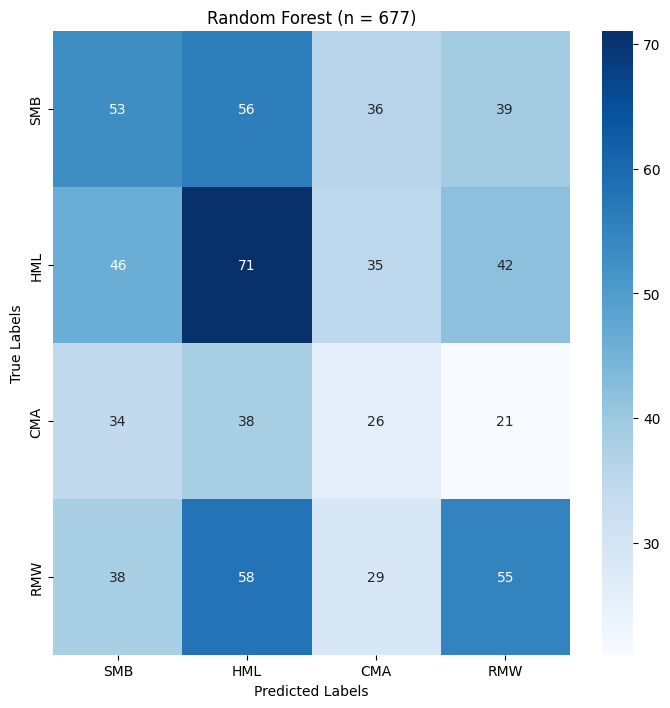

Model,Accuracy,Precision,Recall,F1 Score,Samples
Random Forest,0.3028,0.3049,0.3028,0.3028,677


In [425]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# Use FACTORS directly as labels for the confusion matrix axes.
labels = FACTORS

# Determine how many models we have.
num_models = len(results_dfs)

# Create a figure with 1 row and num_models columns.
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(8 * num_models, 8))
if num_models == 1:
    axes = [axes]  # Make it iterable

# A dictionary to hold overall metrics for each model.
overall_metrics_dict = {}

# Iterate over the dictionary and plot the overall confusion matrix for each model.
for i, (model_key, results_df) in enumerate(results_dfs.items()):
    # Extract true and predicted winners.
    all_true = results_df['Actual_Winner']
    all_pred = results_df['Predicted_Winner']

    # Compute the overall confusion matrix.
    cm_total = confusion_matrix(all_true, all_pred, labels=labels)

    # Plot the confusion matrix for this model.
    sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")
    axes[i].set_title(f"{model_key} (n = {len(all_true)})")

    # Compute overall performance metrics.
    overall_metrics_dict[model_key] = {
         "Accuracy": accuracy_score(all_true, all_pred),
         "Precision": precision_score(all_true, all_pred, average='weighted', zero_division=0),
         "Recall": recall_score(all_true, all_pred, average='weighted', zero_division=0),
         "F1 Score": f1_score(all_true, all_pred, average='weighted', zero_division=0),
         "Samples": len(all_true)
    }

plt.tight_layout(pad=4.0)
plt.show()

# Build an HTML table summarizing overall performance metrics for all models.
html_overall = "<h3>Overall Performance Metrics Summary (Side by Side)</h3>"
html_overall += "<table border='1' cellpadding='5'><tr><th>Model</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1 Score</th><th>Samples</th></tr>"

for model_key, metrics in overall_metrics_dict.items():
    html_overall += f"<tr><td>{model_key}</td><td>{metrics['Accuracy']:.4f}</td><td>{metrics['Precision']:.4f}</td>"
    html_overall += f"<td>{metrics['Recall']:.4f}</td><td>{metrics['F1 Score']:.4f}</td><td>{metrics['Samples']}</td></tr>"

html_overall += "</table>"

# Display the metrics table.
display(HTML(html_overall))


##Feature importance

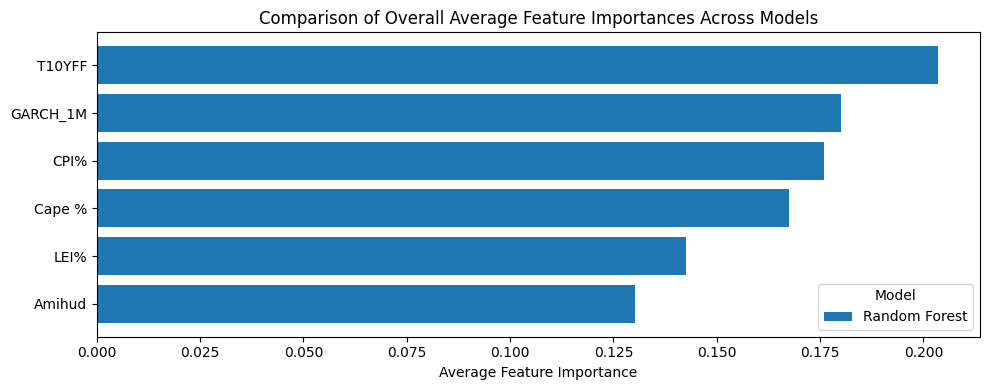

In [426]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume FEATURES is defined (e.g., FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'GARCH_1M'])
# and results_dfs is a dictionary with keys like "RF", "GB", (and maybe "Hybrid")
# where each value is a DataFrame that has a column "Feature_Importances" (an array).

# 1. Compute overall average feature importances for each model.
model_importances = {}
for model_key, df in results_dfs.items():
    # Stack the arrays from the "Feature_Importances" column and average over predictions.
    model_importances[model_key] = np.vstack(df['Feature_Importances'].values).mean(axis=0)

# 2. Create a DataFrame from the computed importances.
# Rows: features, Columns: model keys.
importance_df = pd.DataFrame(model_importances, index=FEATURES)

# Optional: sort features by overall mean importance (averaged across models) so that
# the most important features appear on top.
importance_df['Mean'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values(by='Mean', ascending=False)
sorted_features = importance_df.index.tolist()
importance_df = importance_df.drop(columns=['Mean'])

# 3. Plot a grouped horizontal bar chart.
models = importance_df.columns.tolist()
n_models = len(models)
n_features = len(sorted_features)
y = np.arange(n_features)  # base positions for each feature group
bar_height = 0.8 / n_models  # total group thickness is 0.8

fig, ax = plt.subplots(figsize=(10, max(4, n_features * 0.6)))
for i, model in enumerate(models):
    # Calculate an offset for each model in the group.
    offset = (i - n_models/2) * bar_height + bar_height/2
    ax.barh(y + offset, importance_df.loc[sorted_features, model], height=bar_height, label=model)

ax.set_yticks(y)
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()  # so the top feature is at the top
ax.set_xlabel("Average Feature Importance")
ax.set_title("Comparison of Overall Average Feature Importances Across Models")
ax.legend(title="Model")
plt.tight_layout()
plt.show()


##Allocation chart

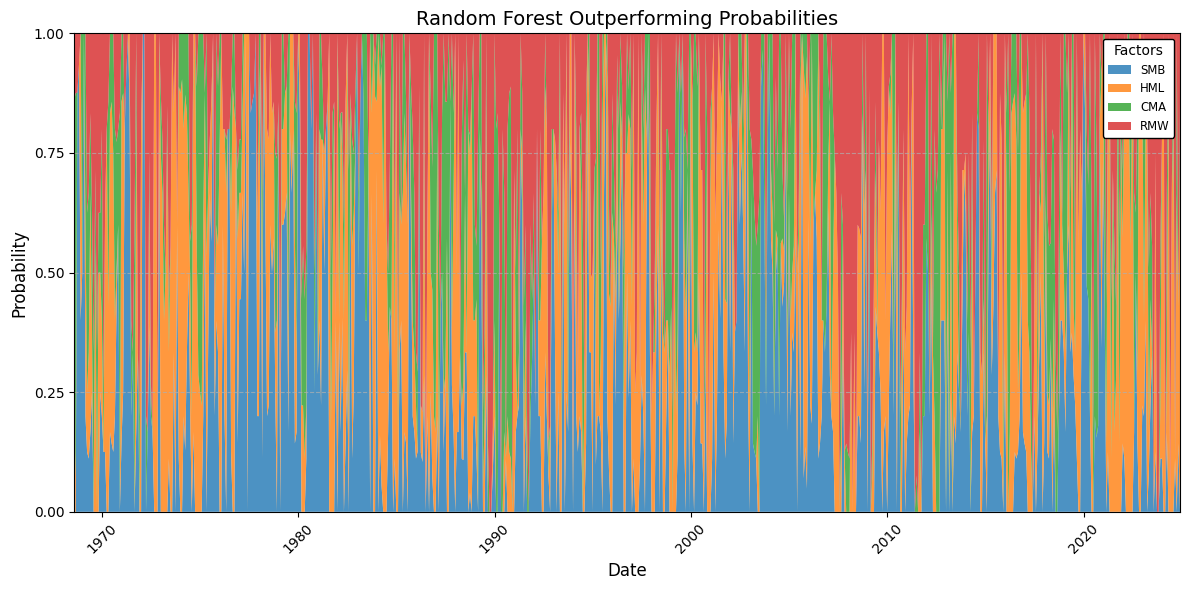

In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine how many models to plot
num_models = len(results_dfs)

# Create subplots: one row per model, sharing the x-axis
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(12, 6 * num_models), sharex=True)
if num_models == 1:
    axes = [axes]  # Ensure iterable if only one model

# Loop through each model's result dataframe
for ax, (model_key, df_model) in zip(axes, results_dfs.items()):
    df_temp = df_model.copy()

    # 1) Convert Predicted_month to datetime (robust handling)
    df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')

    # 2) Drop rows with invalid dates
    df_temp = df_temp.dropna(subset=["Predicted_month"])
    df_temp = df_temp.sort_values("Predicted_month").reset_index(drop=True)

    # 3) Stack probabilities
    full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
    probability_df = pd.DataFrame(full_probs, columns=FACTORS)
    probability_df["Date"] = df_temp["Predicted_month"]

    # 4) Sort by date again (just in case)
    probability_df = probability_df.sort_values("Date").reset_index(drop=True)

    # 5) Plot stackplot
    ax.stackplot(
        probability_df["Date"],
        [probability_df[col] for col in FACTORS],
        labels=FACTORS,
        alpha=0.8
    )

    # ✅ Legend: top right, inside chart, solid white background
    ax.legend(
        loc="upper right",
        fontsize="small",
        title="Factors",
        frameon=True,
        framealpha=1.0,      # fully opaque
        facecolor='white',   # solid background
        edgecolor='black'    # optional: to match style
    )

    # Set title, axes, and formatting
    ax.set_title(f"{model_key} Outperforming Probabilities", fontsize=14)
    ax.set_ylabel("Probability", fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Trim x-axis to data range
    ax.set_xlim(probability_df["Date"].min(), probability_df["Date"].max())

# Final x-axis label and formatting
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Factor weight analysis

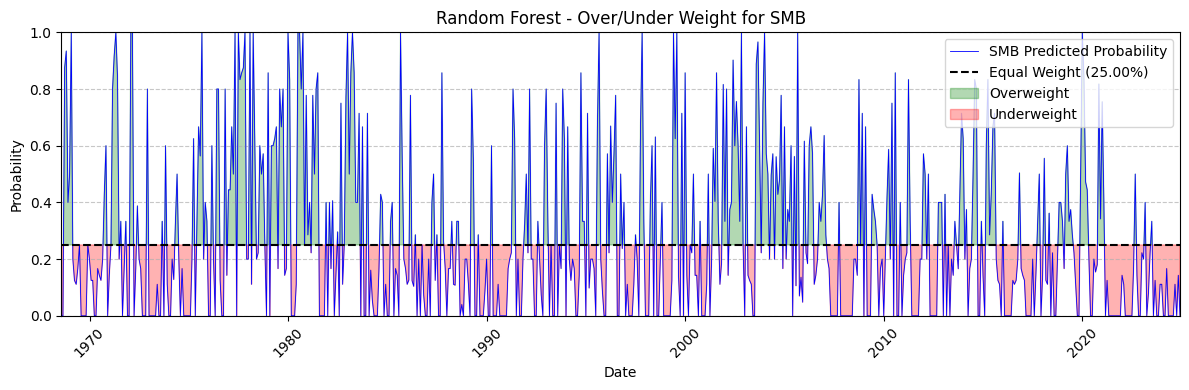

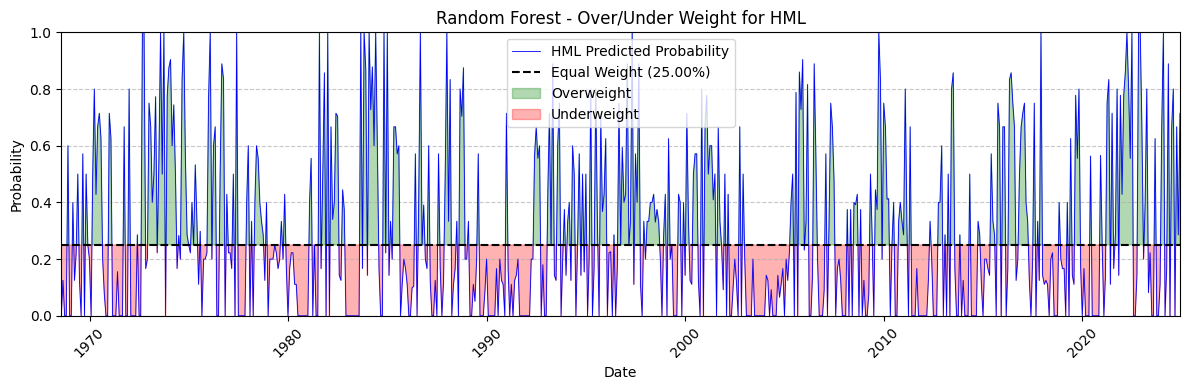

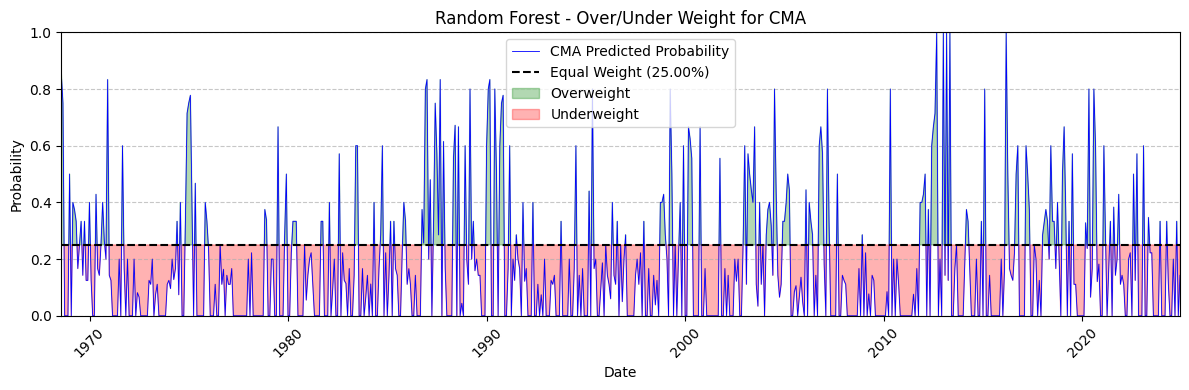

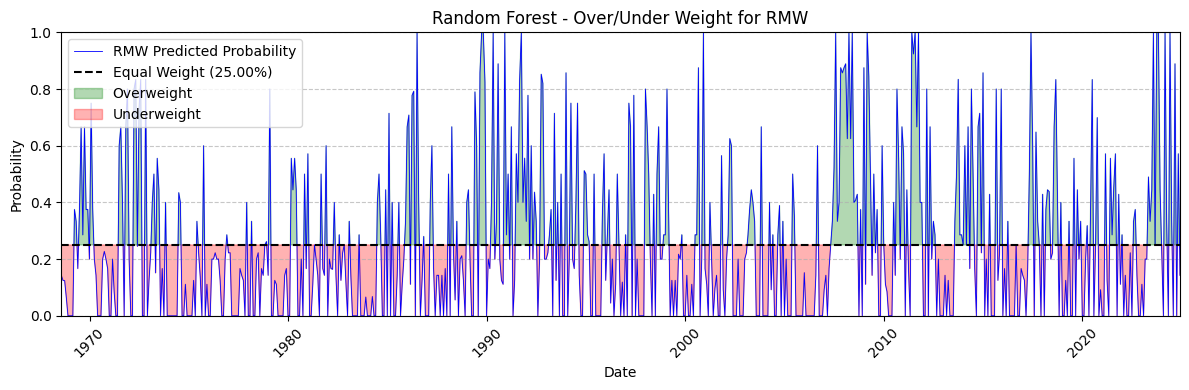

In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Toggle:
combine_all_models = False  # Set to True to combine all models into the same charts; False for individual charts per model

# Set the date range for viewing.
start_date = pd.to_datetime("1968-07-30")
end_date   = pd.to_datetime("2024-11-30")

# Define static equal weight value.
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors equal_weight = 0.20

if combine_all_models:
    # Combined charts: One set of subplots (one per factor) for all models.
    n_factors = len(FACTORS)
    fig, axs = plt.subplots(n_factors, 1, figsize=(12, 4 * n_factors), sharex=False)
    if n_factors == 1:
        axs = [axs]  # ensure axs is iterable

    for i, factor in enumerate(FACTORS):
        ax = axs[i]
        min_dates = []
        max_dates = []

        # Loop through each model's results
        for model_key, df_model in results_dfs.items():
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            # Stack predicted probabilities into a DataFrame.
            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            ax.plot(filtered_df["Date"], filtered_df[factor],
                    label=f"{factor}_{model_key}", linewdth=0.6)

            min_dates.append(filtered_df["Date"].min())
            max_dates.append(filtered_df["Date"].max())

        # Set x-axis limits to exactly the data span (if any data exist)
        if min_dates and max_dates:
            ax.set_xlim(min(min_dates), max(max_dates))

        # Draw the static equal weight horizontal line.
        ax.axhline(equal_weight, color='black', linestyle='--',
                   label=f"Equal Weight ({equal_weight:.2%})")

        ax.set_title(f"{factor} Predicted Probabilities Across Models", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(loc='best', fontsize='small')

    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    # Separate charts: Loop over each model and for each factor create individual charts.
    for model_key, df_model in results_dfs.items():
        for factor in FACTORS:
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            plt.figure(figsize=(12, 4))
            plt.plot(filtered_df["Date"], filtered_df[factor],
                     label=f"{factor} Predicted Probability", color='blue', linewidth=0.6)

            plt.axhline(equal_weight, color='black', linestyle='--',
                        label=f"Equal Weight ({equal_weight:.2%})")

            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] > equal_weight),
                             interpolate=True, color='green', alpha=0.3, label='Overweight')
            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] < equal_weight),
                             interpolate=True, color='red', alpha=0.3, label='Underweight')

            plt.title(f"{model_key} - Over/Under Weight for {factor}")
            plt.xlabel("Date")
            plt.ylabel("Probability")
            plt.ylim(0, 1)
            # Set x-axis limits to exactly where data exists.
            plt.xlim(filtered_df["Date"].min(), filtered_df["Date"].max())
            plt.legend(loc='best')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


##Total outperforming probabilities

Model,SMB,HML,CMA,RMW
Random Forest,0.2749,0.295,0.1775,0.2526


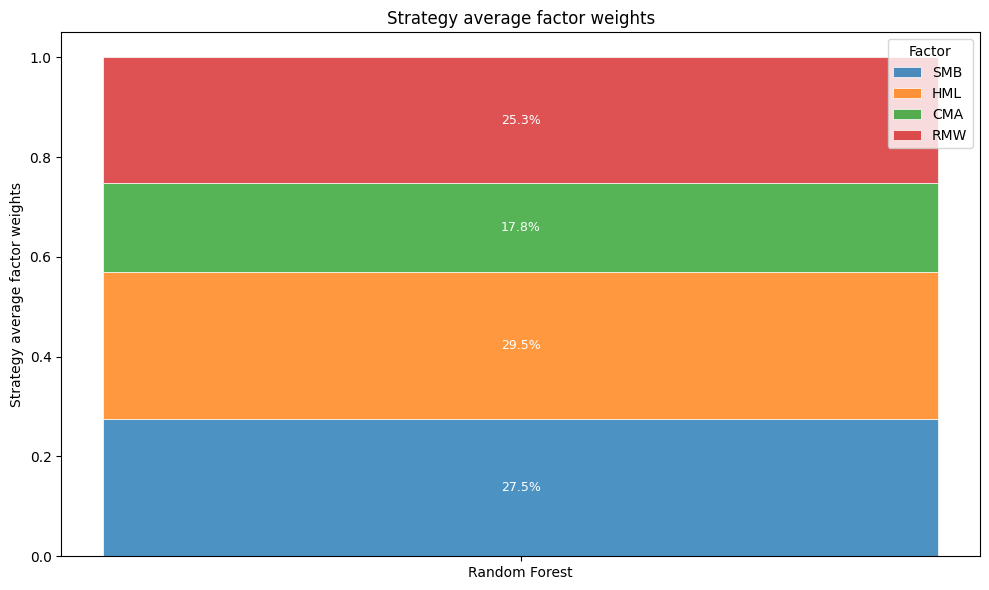

In [429]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# ----------------------------------------------------
# 1. Compute average predicted probabilities per model
# ----------------------------------------------------
avg_probs_dict = {}

for model_key, df_model in results_dfs.items():
    full_probs = np.vstack(df_model["Predicted_Probabilities"].values)
    avg = full_probs.mean(axis=0)
    avg_probs_dict[model_key] = pd.Series(avg, index=FACTORS)

# Create a DataFrame where rows = models, columns = factors
avg_probs_df = pd.DataFrame(avg_probs_dict).T
avg_probs_df.index.name = "Model"
avg_probs_df = avg_probs_df.round(4)

# ----------------------------------------------------
# 2. Generate consistent factor colors from stackplot
# ----------------------------------------------------
# Use a dummy stackplot to extract the assigned factor colors
_, ax_dummy = plt.subplots()
dummy_data = np.random.rand(10, len(FACTORS))
dummy_dates = pd.date_range("2000-01-01", periods=10)
stack = ax_dummy.stackplot(dummy_dates, dummy_data.T, labels=FACTORS, alpha=0.8)
plt.close()  # We don’t want to display this

# Build color map: factor name → RGBA color
factor_colors = {factor: poly.get_facecolor()[0] for factor, poly in zip(FACTORS, stack)}

# ----------------------------------------------------
# 3. Display HTML Table
# ----------------------------------------------------
html_table = avg_probs_df.reset_index().to_html(index=False, classes="table table-striped table-bordered", border=0)
display(HTML("<h3>Average Outperforming Probabilities by Model</h3>" + html_table))

# ----------------------------------------------------
# 4. Stacked Bar Chart with Consistent Colors and Labels
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(avg_probs_df))
x = np.arange(len(avg_probs_df))

for factor in FACTORS:
    values = avg_probs_df[factor].values
    bars = ax.bar(x, values, bottom=bottom,
                  label=factor,
                  color=factor_colors[factor],
                  edgecolor="white",
                  linewidth=0.5)

    # Centered labels
    for bar, val in zip(bars, values):
        if val > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val * 100:.1f}%",
                ha="center", va="center", fontsize=9, color="white"
            )

    bottom += values

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(avg_probs_df.index)
ax.set_ylabel("Strategy average factor weights")
ax.set_title("Strategy average factor weights")
ax.legend(title="Factor", loc="upper right")
plt.tight_layout()
plt.show()


#Return data

In [430]:
import pandas as pd
from IPython.display import display

# ==============================================================================
# Step 0: Define column orders based on your requirements
# ------------------------------------------------------------------------------
# Common columns that are identical across all models.
common_cols = ['Predicted_month', 'Mkt', 'RF', 'Mkt-RF', 'Us_standard'] + FACTORS + ['Equal_Weight_Return', 'Actual_Winner']

# Model-specific columns that will be renamed.
model_specific_cols = ['Allocated_Return', 'Predicted_Winner']

# ==============================================================================
# Step 1. Build a base common DataFrame from one model's merged results.
# ------------------------------------------------------------------------------
# Take the first model as the base to extract common columns.
base_key, base_df = list(results_dfs.items())[0]
base_df = base_df.copy()
base_df['Predicted_month'] = pd.to_datetime(base_df['Predicted_month'], errors='coerce')

# Merge with df_sorted (the master DataFrame sorted by date) on date.
base_df_local = base_df.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')
common_df = base_df_local[[c for c in common_cols if c in base_df_local.columns]].copy()

# ==============================================================================
# Step 2. Process each model individually to extract the model-specific columns.
# ------------------------------------------------------------------------------
# We'll assign a new display name using numbering such that each model gets:
# "ML{number}: {Model Name}"
model_dfs = []         # Will hold one DataFrame per model.
new_model_names = []   # To store new model names.
for i, (model_key, df_model) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_key}"  # New display name.
    new_model_names.append(new_model_name)

    df_temp = df_model.copy()
    df_temp['Predicted_month'] = pd.to_datetime(df_temp['Predicted_month'], errors='coerce')

    # Merge with df_sorted on 'Predicted_month' = 'Date'
    df_temp_local = df_temp.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')

    # Keep only the 'Predicted_month' plus the model-specific columns.
    subset_cols = ['Predicted_month'] + [col for col in model_specific_cols if col in df_temp_local.columns]
    df_subset = df_temp_local[subset_cols].copy()

    # Rename model-specific columns with the new model name.
    rename_dict = {}
    for col in model_specific_cols:
        if col in df_subset.columns:
            rename_dict[col] = f"{new_model_name} {col}"
    df_subset.rename(columns=rename_dict, inplace=True)

    model_dfs.append(df_subset)

# ==============================================================================
# Step 3. Merge each model-specific DataFrame with the common DataFrame.
# ------------------------------------------------------------------------------
combined_df = common_df.copy()
for df_sub in model_dfs:
    combined_df = combined_df.merge(df_sub, on='Predicted_month', how='left')

# ==============================================================================
# Step 4. Reorder the columns to match the desired order.
# ------------------------------------------------------------------------------
benchmark_cols = ['Mkt', 'RF', 'Mkt-RF', 'Us_standard']
common_order = ['Predicted_month'] + benchmark_cols + FACTORS
# Model-specific allocated return columns.
allocated_cols = [f"{name} Allocated_Return" for name in new_model_names]
# Model-specific predicted winner columns.
predicted_cols = [f"{name} Predicted_Winner" for name in new_model_names]

final_order = common_order + ['Equal_Weight_Return'] + allocated_cols + ['Actual_Winner'] + predicted_cols
final_order = [col for col in final_order if col in combined_df.columns]

combined_df = combined_df[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ==============================================================================
# Step 5. Display the final combined results table.
# ------------------------------------------------------------------------------
display(combined_df)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).max())


,Predicted_month,Mkt,RF,Mkt-RF,SMB,HML,CMA,RMW,Equal_Weight_Return,ML1: Random Forest Allocated_Return,Actual_Winner,ML1: Random Forest Predicted_Winner
0,1968-07-30,-0.0224,0.0048,-0.0272,-0.034475,0.003307,-0.012159,-0.045134,-0.022115,-0.016870,HML,CMA
1,1968-08-30,0.0176,0.0042,0.0134,0.038734,0.035263,0.032823,0.026502,0.033331,0.032338,SMB,CMA
2,1968-09-30,0.0446,0.0043,0.0403,0.070119,0.056771,0.065289,0.053285,0.061366,0.068031,SMB,SMB
3,1968-10-30,0.0086,0.0044,0.0042,0.006880,0.022650,0.018646,-0.000053,0.012031,0.006422,HML,SMB
4,1968-11-30,0.0585,0.0042,0.0543,0.079004,0.061148,0.050731,0.068719,0.064901,0.068290,SMB,HML
...,...,...,...,...,...,...,...,...,...,...,...,...
672,2024-07-30,0.0169,0.0045,0.0124,0.102676,0.098018,0.050357,0.055666,0.076679,0.088485,SMB,HML
673,2024-08-30,0.0209,0.0048,0.0161,-0.014352,0.001081,0.006999,0.005744,-0.000132,0.003511,CMA,RMW
674,2024-09-30,0.0214,0.0040,0.0174,0.009720,-0.004265,0.014712,0.019865,0.010008,0.002061,RMW,HML
675,2024-10-30,-0.0058,0.0039,-0.0097,-0.008759,0.004004,0.003551,-0.018643,-0.004962,-0.010761,HML,RMW



First date in 'Predicted_month': 1968-07-30 00:00:00
Last date in 'Predicted_month': 2024-11-30 00:00:00


In [441]:
import pandas as pd
import numpy as np
import textwrap

# Ensure "Year" column exists
if 'Year' not in combined_df.columns:
    combined_df['Year'] = combined_df['Predicted_month'].dt.year

# Identify ML return columns and create a name map to remove "Allocated_Return"
ml_return_cols = [c for c in combined_df.columns if 'Allocated_Return' in c]
ml_name_map = {ml: ml.replace("Allocated_Return", "").strip() for ml in ml_return_cols}

# Helper: Compute annual metrics (RF-adjusted)
def compute_annual_metrics(returns: pd.Series, rf: pd.Series):
    returns = returns.dropna()
    if returns.empty:
        return np.nan, np.nan, np.nan
    rf = rf.reindex(returns.index)
    ann_ret = (1 + returns).prod() - 1
    ann_rf  = (1 + rf).prod() - 1
    ann_ex_ret = ann_ret - ann_rf
    ann_vol = (returns - rf).std() * np.sqrt(12)
    ann_sharpe = ann_ex_ret / ann_vol if ann_vol else np.nan
    return ann_ret, ann_vol, ann_sharpe

# Build df_metrics (raw values) and df_excess (excess over Equal Weight)
metrics_rows, excess_rows = [], []
for year, grp in combined_df.groupby('Year'):
    ew_ret, ew_vol, ew_sharpe = compute_annual_metrics(grp['Equal_Weight_Return'], grp['RF'])
    row_m = {'Year': year,
             'Equal_Weight Return': ew_ret,
             'Equal_Weight Vol':    ew_vol,
             'Equal_Weight Sharpe': ew_sharpe}
    row_e = {'Year': year}

    for ml in ml_return_cols:
        ml_short = ml_name_map[ml]
        ml_ret, ml_vol, ml_sharpe = compute_annual_metrics(grp[ml], grp['RF'])
        row_m[f"{ml_short} Return"]  = ml_ret
        row_m[f"{ml_short} Vol"]     = ml_vol
        row_m[f"{ml_short} Sharpe"]  = ml_sharpe

        row_e[f"{ml_short} Excess Return"]  = ml_ret - ew_ret
        row_e[f"{ml_short} Excess Vol"]     = ml_vol - ew_vol
        row_e[f"{ml_short} Excess Sharpe"]  = ml_sharpe - ew_sharpe

    metrics_rows.append(row_m)
    excess_rows.append(row_e)

df_metrics = pd.DataFrame(metrics_rows).set_index('Year').sort_index()
df_excess  = pd.DataFrame(excess_rows).set_index('Year').sort_index()

# Function: Insert newline breaks for column names longer than max_width characters.
def wrap_colname(colname, max_width=15):
    lines = textwrap.wrap(colname, width=max_width)
    return "\n".join(lines)

# Apply wrapping to all column names
df_metrics.columns = [wrap_colname(col) for col in df_metrics.columns]
df_excess.columns  = [wrap_colname(col) for col in df_excess.columns]

# Function: Style dataframe to enable multiline headers and format numbers with a max of 3 decimals.
# Note: The underlying DataFrame values remain unrounded.
def style_with_wrapping_and_format(df):
    styled = df.style.set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('white-space', 'pre-wrap'),  # allow multiline
                ('word-wrap', 'break-word')     # break long words
            ]
        }
    ]).format(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
    return styled

# Display the raw metrics and excess metrics with formatted output.
display(style_with_wrapping_and_format(df_metrics))
display(style_with_wrapping_and_format(df_excess))

# -----------------------------------------------------------------
# Summary: Count how often each ML strategy "beats" Equal Weight.
#  - Excess Return is "better" if > 0.
#  - Excess Volatility is "better" if < 0.
#  - Excess Sharpe is "better" if > 0.
#
# Average excess metrics are now calculated from all observations.
# -----------------------------------------------------------------
summary_rows = []
total_years = len(df_excess)

# Helper: Wrap names for summary columns
def w(ml_short, suffix):
    return wrap_colname(f"{ml_short} {suffix}")

for ml in ml_return_cols:
    ml_short = ml_name_map[ml]
    ret_series    = df_excess[w(ml_short, "Excess Return")]
    vol_series    = df_excess[w(ml_short, "Excess Vol")]
    sharpe_series = df_excess[w(ml_short, "Excess Sharpe")]

    ret_pos_count    = (ret_series > 0).sum()
    vol_neg_count    = (vol_series < 0).sum()
    sharpe_pos_count = (sharpe_series > 0).sum()

    # Average excess metrics now computed over all observations:
    avg_ret    = ret_series.mean()
    avg_vol    = vol_series.mean()
    avg_sharpe = sharpe_series.mean()

    summary_rows.append({
        "Strategy": ml_short,
        "Excess Return (Positive) Count": f"{ret_pos_count}/{total_years}",
        "Avg Excess Return":   avg_ret,
        "Excess Vol (Negative) Count":    f"{vol_neg_count}/{total_years}",
        "Avg Excess Vol":      avg_vol,
        "Excess Sharpe (Positive) Count": f"{sharpe_pos_count}/{total_years}",
        "Avg Excess Sharpe":   avg_sharpe
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.columns = [wrap_colname(col) for col in summary_df.columns]

display(style_with_wrapping_and_format(summary_df))


,Equal_Weight Return,Equal_Weight Vol,Equal_Weight Sharpe,ML1: Random Forest Return,ML1: Random Forest Vol,ML1: Random Forest Sharpe
Year,,,,,,
1968,0.137,0.130,0.849,0.157,0.129,1.009
1969,-0.189,0.178,-1.431,-0.187,0.169,-1.494
1970,-0.004,0.249,-0.278,0.029,0.247,-0.147
1971,0.196,0.190,0.798,0.230,0.194,0.962
1972,0.097,0.116,0.503,0.162,0.121,1.024
1973,-0.271,0.236,-1.439,-0.221,0.208,-1.391
1974,-0.227,0.213,-1.439,-0.191,0.208,-1.301
1975,0.544,0.256,1.899,0.523,0.242,1.925
1976,0.434,0.205,1.871,0.486,0.232,1.879


,ML1: Random Forest Excess Return,ML1: Random Forest Excess Vol,ML1: Random Forest Excess Sharpe
Year,,,
1968,0.020,-0.001,0.160
1969,0.002,-0.009,-0.062
1970,0.033,-0.002,0.130
1971,0.034,0.004,0.163
1972,0.065,0.005,0.520
1973,0.050,-0.028,0.048
1974,0.036,-0.005,0.138
1975,-0.021,-0.014,0.026
1976,0.052,0.027,0.008


,Strategy,Excess Return (Positive) Count,Avg Excess Return,Excess Vol (Negative) Count,Avg Excess Vol,Excess Sharpe (Positive) Count,Avg Excess Sharpe
0,ML1: Random Forest,38/57,0.014,33/57,-0.000,38/57,0.082


##Cumulative returns table

In [431]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# PRELIMINARY: Use the merged multi-model table (combined_df)
# ---------------------------------------------------------------------
start_date = pd.to_datetime('2010-01-01')
end_date   = pd.to_datetime('2024-12-30')
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Rename benchmark column if present (using the first element of BENCHMARK)
rename_dict = {}
if BENCHMARK[0] in df_filtered.columns:
    rename_dict[BENCHMARK[0]] = 'Benchmark Return'
df_filtered.rename(columns=rename_dict, inplace=True)

# ---------------------------------------------------------------------
# Remove RF from factors (we exclude it)
factors_to_use = [fac for fac in FACTORS if fac.upper() != 'RF']

# Define possible benchmark columns (for cumulative returns).
possible_bench = ["Benchmark Return", "Mkt", "Mkt-RF", "Us_standard"]
benchmark_cols = [col for col in possible_bench if col in df_filtered.columns]

# ---------------------------------------------------------------------
# Calculate Equal-Weighted Returns based on factors_to_use.
if all(f in df_filtered.columns for f in factors_to_use):
    df_filtered['Equal Factor Weight Strategy Return'] = df_filtered[factors_to_use].mean(axis=1)
    equal_ret_col_list = ['Equal Factor Weight Strategy Return']
else:
    equal_ret_col_list = []

# ---------------------------------------------------------------------
# Predicted Winner Weighted Strategy Return:
# Use the base model's predicted winner column using new naming.
base_model_key = list(results_dfs.keys())[0]
base_model_new = f"ML1: {base_model_key}"  # First model is ML1.
base_model_pred_col = f"{base_model_new} Predicted_Winner"
if base_model_pred_col in df_filtered.columns:
    df_filtered['Predicted_Winner'] = df_filtered[base_model_pred_col]

def calc_winner_strategy(row):
    pred = row['Predicted_Winner']
    if pred in factors_to_use:
        other_factors = [f for f in factors_to_use if f != pred]
        if other_factors:
            return 0.5 * row[pred] + 0.5 * row[other_factors].mean()
        else:
            return row[pred]
    else:
        return row[factors_to_use].mean()

df_filtered['Predicted Winner Weighted Strategy Return'] = df_filtered.apply(calc_winner_strategy, axis=1)

# ---------------------------------------------------------------------
# Compute cumulative returns for each return series.
# We'll work on a copy for cumulative computations.
cum = df_filtered.copy()

# 1. For each model's allocated return (using new names).
allocated_cum_cols = []
new_model_names = [f"ML{i}: {model_key}" for i, model_key in enumerate(results_dfs.keys(), 1)]
for name in new_model_names:
    col_alloc = f"{name} Allocated_Return"
    if col_alloc in cum.columns:
        new_cum_col = col_alloc.replace("Allocated_Return", "Cumulative Allocated Return")
        cum[new_cum_col] = (1 + cum[col_alloc]).cumprod() - 1
        allocated_cum_cols.append(new_cum_col)

# 2. For equal factor weight returns.
if 'Equal Factor Weight Strategy Return' in cum.columns:
    cum['Equal Factor Weight Cumulative Return'] = (1 + cum['Equal Factor Weight Strategy Return']).cumprod() - 1
    equal_cum_cols = ['Equal Factor Weight Cumulative Return']
else:
    equal_cum_cols = []

# 3. For each benchmark column.
bench_cum_cols = []
# If "Benchmark Return" is available, use the actual benchmark name from BENCHMARK[0].
if "Benchmark Return" in cum.columns:
    new_bench_col = f"{BENCHMARK[0]} Cumulative Return"
    cum[new_bench_col] = (1 + cum["Benchmark Return"]).cumprod() - 1
    bench_cum_cols.append(new_bench_col)
# Process any other benchmark columns
for col in benchmark_cols:
    if col != "Benchmark Return":
        new_col = col + " Cumulative Return"
        cum[new_col] = (1 + cum[col]).cumprod() - 1
        bench_cum_cols.append(new_col)

# 4. For Predicted Winner Weighted Strategy Return.
if 'Predicted Winner Weighted Strategy Return' in cum.columns:
    cum['Predicted Winner Weighted Cumulative Return'] = (1 + cum['Predicted Winner Weighted Strategy Return']).cumprod() - 1

# 5. For each factor in factors_to_use: compute cumulative returns.
factor_cum_cols = []
for fac in factors_to_use:
    if fac in cum.columns:
        new_name = fac + " Cumulative"
        cum[new_name] = (1 + cum[fac]).cumprod() - 1
        factor_cum_cols.append(new_name)

# ---------------------------------------------------------------------
# Build the final cumulative returns table.
# Final order:
#   a. Common columns: Predicted_month, then benchmark cumulative returns, then factor cumulative returns.
#   b. Then Equal Factor Weight Cumulative Return.
#   c. Then each model's Cumulative Allocated Return.
#   d. Then Predicted Winner Weighted Cumulative Return.
# ---------------------------------------------------------------------
final_common_order = ['Predicted_month'] + bench_cum_cols + factor_cum_cols
final_order = final_common_order + equal_cum_cols + allocated_cum_cols
if 'Predicted Winner Weighted Cumulative Return' in cum.columns:
    final_order.append('Predicted Winner Weighted Cumulative Return')

final_order = [col for col in final_order if col in cum.columns]
cumulative_table = cum[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ---------------------------------------------------------------------
# Display the Final Cumulative Returns Table.
# ---------------------------------------------------------------------
print("Cumulative Returns Table:")
display(cumulative_table)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).max())


Cumulative Returns Table:


,Predicted_month,Mkt Cumulative Return,Mkt-RF Cumulative Return,SMB Cumulative,HML Cumulative,CMA Cumulative,RMW Cumulative,Equal Factor Weight Cumulative Return,ML1: Random Forest Cumulative Allocated Return,Predicted Winner Weighted Cumulative Return
0,2010-01-30,-0.033600,-0.033600,-0.031970,-0.035682,-0.036149,-0.037511,-0.035328,-0.035060,-0.035446
1,2010-02-28,-0.000742,-0.000742,0.014860,0.026385,0.013253,0.004165,0.014665,0.017791,0.013433
2,2010-03-30,0.062411,0.062311,0.095974,0.111914,0.097934,0.074865,0.095137,0.100570,0.094016
3,2010-04-30,0.083765,0.083557,0.163822,0.170610,0.154564,0.122384,0.152764,0.159609,0.151204
4,2010-05-30,-0.001636,-0.001936,0.076573,0.063974,0.056396,0.042234,0.059823,0.068001,0.060559
...,...,...,...,...,...,...,...,...,...,...
174,2024-07-30,5.414386,4.530179,4.215149,4.048622,5.133573,5.906467,4.851008,6.106163,5.206428
175,2024-08-30,5.548447,4.619215,4.140302,4.054079,5.176502,5.946135,4.850235,6.131110,5.217764
176,2024-09-30,5.688583,4.716989,4.190265,4.032524,5.267370,6.084120,4.908784,6.145805,5.250409
177,2024-10-30,5.649790,4.661535,4.144805,4.052671,5.289626,5.952050,4.879466,6.068912,5.190891



First date in 'Predicted_month': 2010-01-30 00:00:00
Last date in 'Predicted_month': 2024-11-30 00:00:00


##Cumulative returns chart

Updated plotting range: 2010-01-30 00:00:00 to 2024-11-30 00:00:00
Columns available for plotting: ['Predicted_month', 'Mkt Cumulative Return', 'Mkt-RF Cumulative Return', 'SMB Cumulative', 'HML Cumulative', 'CMA Cumulative', 'RMW Cumulative', 'Equal Factor Weight Cumulative Return', 'ML1: Random Forest Cumulative Allocated Return', 'Predicted Winner Weighted Cumulative Return']


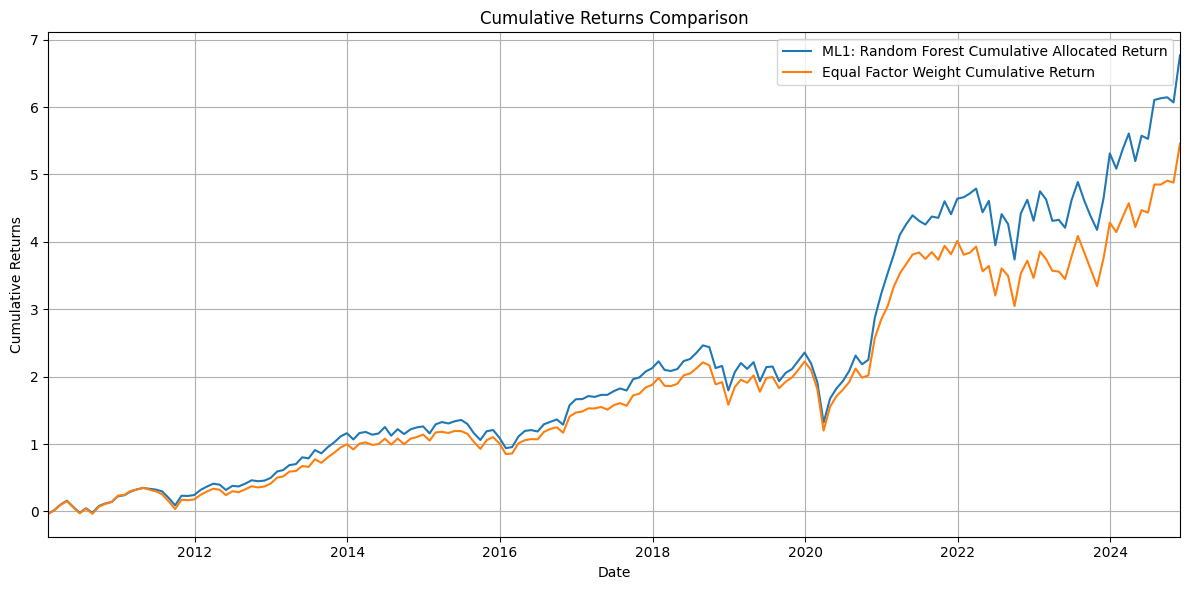

In [432]:
import matplotlib.pyplot as plt

# Toggle settings
show_50_50_strategy = False  # Toggle for the 50%/50% predicted winner weighted strategy line.
show_benchmark = False       # Toggle for showing benchmark cumulative return(s).
use_log_scale = False         # Toggle for logarithmic (True) or linear (False) y-axis scale.

# Use the cumulative_table built in Cell 2.
df_plot = cumulative_table.copy()

# Determine the plotting date range.
start_date = df_plot['Predicted_month'].min()
end_date   = df_plot['Predicted_month'].max()
print(f"Updated plotting range: {start_date} to {end_date}")
print("Columns available for plotting:", df_plot.columns.tolist())

if start_date == end_date:
    print("⚠ Warning: The dataset might not have updated properly. Try rerunning the previous cell!")

plt.figure(figsize=(12, 6))
plt.clf()  # Clear the figure

# --- Plot each model's cumulative allocated return ---
for col in df_plot.columns:
    if "Cumulative Allocated Return" in col:
        plt.plot(df_plot['Predicted_month'], df_plot[col], label=col)

# --- Plot equal factor weight cumulative return ---
if 'Equal Factor Weight Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Equal Factor Weight Cumulative Return'],
             label='Equal Factor Weight Cumulative Return')

# --- Plot benchmark cumulative returns, if toggle is set ---
if show_benchmark:
    if 'Benchmark Cumulative Return' in df_plot.columns:
        plt.plot(df_plot['Predicted_month'], df_plot['Benchmark Cumulative Return'],
                 label='Benchmark Cumulative Return')
    for col in df_plot.columns:
        # Only plot columns with "Mkt" or "Us_standard" that do NOT include "Mkt-RF"
        if (("Mkt" in col or "Us_standard" in col) and
            "Cumulative Return" in col and "Mkt-RF" not in col and col != "Benchmark Cumulative Return"):
            plt.plot(df_plot['Predicted_month'], df_plot[col], label=col)

# --- Plot Predicted Winner Weighted Cumulative Return if available and toggle is on ---
if show_50_50_strategy and 'Predicted Winner Weighted Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Predicted Winner Weighted Cumulative Return'],
             label='50%/50% Predicted Winner Strategy')

# --- Format and display the chart ---
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)

# Toggle the y-axis scale
if use_log_scale:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.tight_layout()
plt.show()


#PERFORMANCE METRICS

In [433]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annualized_metrics(monthly_returns):
    """
    Compute the annualized return, volatility, and Sharpe ratio from monthly returns.
    Assumes monthly returns.
    """
    # Fill missing values with 0 to avoid issues.
    monthly_returns = monthly_returns.fillna(0)
    mean_m = monthly_returns.mean()
    std_m = monthly_returns.std()
    ann_ret = mean_m * 12
    ann_vol = std_m * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

def max_drawdown(monthly_returns):
    """
    Compute the maximum drawdown from a series of monthly returns.
    """
    wealth = (1 + monthly_returns.fillna(0)).cumprod()
    dd_series = wealth / wealth.cummax() - 1
    return dd_series.min()

# ---------------------------------------------------------------------
# Determine the raw return columns from combined_df.
# We assume:
# • "Predicted_month" is the date column.
# • Raw (monthly) return strategy columns either contain "Return"
#   (e.g. "ML1: Random Forest Allocated_Return")
#   OR exactly match BENCHMARK[0] (e.g. "Mkt") or "Benchmark Return"
# We exclude any column that contains "Cumulative" as well as non-return columns.
# ---------------------------------------------------------------------
all_columns = combined_df.columns.tolist()
# Include columns that (a) have "Return" in them (but not "Cumulative"), OR
# are exactly equal to BENCHMARK[0] or "Benchmark Return"
strategy_cols = [
    col for col in all_columns
    if (
         (("Return" in col) or (col == BENCHMARK[0]) or (col == "Benchmark Return"))
         and ("Cumulative" not in col)
         and (col not in ["Actual_Winner", "Predicted_month"])
       )
]

# Display the list of strategy columns for debugging.
print("Strategy columns used for performance metrics:")
print(strategy_cols)

# ---------------------------------------------------------------------
# Loop through each selected strategy column and compute performance metrics.
# ---------------------------------------------------------------------
metrics_list = []
for col in strategy_cols:
    monthly_ret_series = combined_df[col]
    ann_ret, ann_vol, sharpe = annualized_metrics(monthly_ret_series)
    mdd = max_drawdown(monthly_ret_series)

    metrics_list.append({
         "Strategy": col,
         "Annualized Return": f"{ann_ret*100:.2f}%",
         "Annualized Volatility": f"{ann_vol*100:.2f}%",
         "Sharpe Ratio": f"{sharpe:.2f}",
         "Max Drawdown": f"{mdd*100:.2f}%"
    })

# Create a DataFrame with the performance metrics.
metrics_df = pd.DataFrame(metrics_list).sort_values("Strategy").reset_index(drop=True)

# Optionally, sort by another metric (e.g., Sharpe Ratio) if desired.
# metrics_df = metrics_df.sort_values("Sharpe Ratio", ascending=False).reset_index(drop=True)

# Display the performance metrics as an HTML table.
display(HTML(metrics_df.to_html(index=False)))



=== PERFORMANCE METRICS ===
Strategy columns used for performance metrics:
['Mkt', 'Equal_Weight_Return', 'ML1: Random Forest Allocated_Return']


Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Equal_Weight_Return,13.73%,18.23%,0.75,-54.10%
ML1: Random Forest Allocated_Return,15.01%,18.18%,0.83,-50.42%
Mkt,11.34%,15.85%,0.72,-50.39%


##Drawdown chart

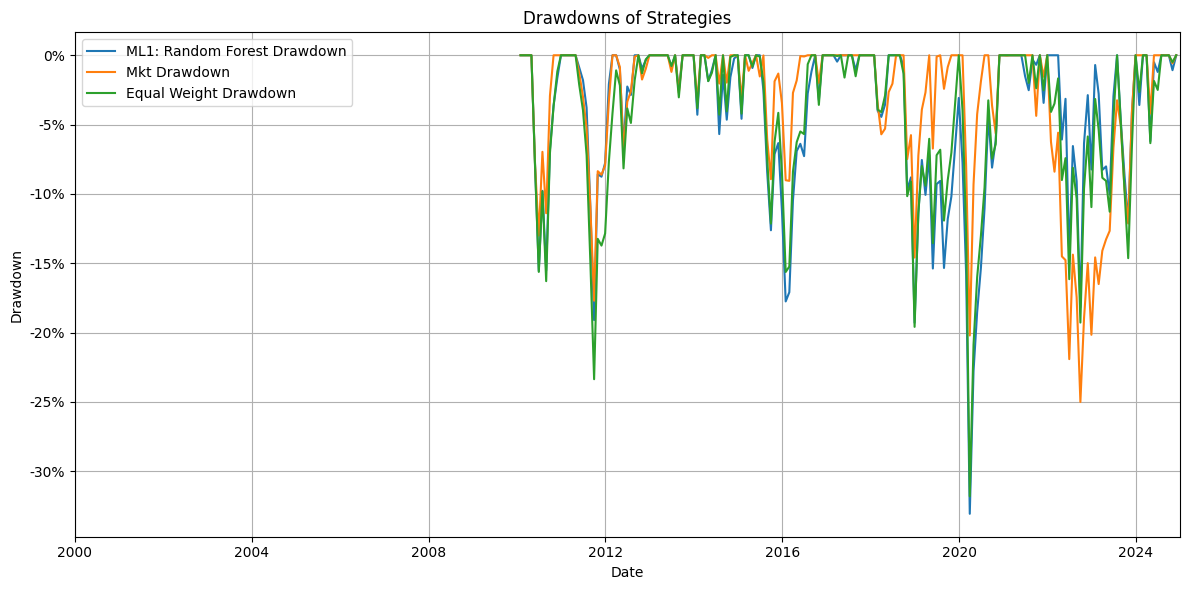

In [434]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -------------------------------------------------------------------------
# 1. TOGGLE OPTIONS
# -------------------------------------------------------------------------
show_benchmark_drawdown = True           # Toggle benchmark drawdown
show_equal_weight_drawdown = True        # Toggle Equal Weight (single) drawdown
show_winner_weighted_drawdown = False     # Toggle Winner Weighted drawdown

# -------------------------------------------------------------------------
# 2. COPY cumulative_table (assumed computed previously)
# -------------------------------------------------------------------------
drawdown_df = cumulative_table.copy()

# -------------------------------------------------------------------------
# 3. CALCULATE DRAWDOWNS USING WEALTH INDEX (Wealth = 1 + Cumulative Return)
# -------------------------------------------------------------------------

# a) For each ML model's cumulative allocated return column:
ml_alloc_cols = [col for col in drawdown_df.columns if "Cumulative Allocated Return" in col]
for col in ml_alloc_cols:
    wealth = 1 + drawdown_df[col]
    drawdown_name = col.replace("Cumulative Allocated Return", "Drawdown")
    drawdown_df[drawdown_name] = wealth / wealth.cummax() - 1

# b) For Benchmark:
# Use the benchmark name from BENCHMARK[0]
benchmark_name = BENCHMARK[0]  # for example, "Mkt"
benchmark_cum_col = f"{benchmark_name} Cumulative Return"
if benchmark_cum_col in drawdown_df.columns:
    wealth = 1 + drawdown_df[benchmark_cum_col]
    drawdown_df[f"{benchmark_name} Drawdown"] = wealth / wealth.cummax() - 1
elif "Mkt Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Mkt Cumulative Return"]
    drawdown_df["Mkt Drawdown"] = wealth / wealth.cummax() - 1
else:
    print("WARNING: No benchmark cumulative return column found.")

# c) For Equal Weight (single version):
if "Equal Factor Weight Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Equal Factor Weight Cumulative Return"]
    drawdown_df["Equal Weight Drawdown"] = wealth / wealth.cummax() - 1

# d) For Predicted Winner Weighted:
if "Predicted Winner Weighted Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Predicted Winner Weighted Cumulative Return"]
    drawdown_df["Winner Weighted Drawdown"] = wealth / wealth.cummax() - 1

# -------------------------------------------------------------------------
# 4. FILTER BY DATE RANGE
# -------------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")
drawdown_df["Predicted_month"] = pd.to_datetime(drawdown_df["Predicted_month"])
plot_df = drawdown_df[(drawdown_df["Predicted_month"] >= start_date) &
                      (drawdown_df["Predicted_month"] <= end_date)]

# -------------------------------------------------------------------------
# 5. PLOT THE DRAWDOWNS
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.clf()  # Clear any existing figure

# a) Plot each ML model's drawdown (those columns that start with "ML" and contain "Drawdown")
for col in plot_df.columns:
    if col.startswith("ML") and "Drawdown" in col:
        plt.plot(plot_df["Predicted_month"], plot_df[col], label=col)

# b) Plot Benchmark Drawdown if toggled on
if show_benchmark_drawdown:
    # Look for the benchmark drawdown column with the actual benchmark name (e.g., "Mkt Drawdown")
    bench_drawdown_col = f"{benchmark_name} Drawdown"
    if bench_drawdown_col in plot_df.columns:
        plt.plot(plot_df["Predicted_month"], plot_df[bench_drawdown_col], label=bench_drawdown_col)

# c) Plot Equal Weight Drawdown if available
if show_equal_weight_drawdown and "Equal Weight Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Equal Weight Drawdown"], label="Equal Weight Drawdown")

# d) Plot Winner Weighted Drawdown if toggled on
if show_winner_weighted_drawdown and "Winner Weighted Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Winner Weighted Drawdown"], label="Winner Weighted Drawdown")

# Format the y-axis as percentages.
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, _: f"{val*100:.0f}%")
)

# -------------------------------------------------------------------------
# 6. ENSURE THE X-AXIS SPANS EXACTLY THE DEFINED DATE RANGE
# -------------------------------------------------------------------------
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.title("Drawdowns of Strategies")
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Regression

In [435]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display, HTML

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
#CHATIN MUKAAN TÄÄ ON TRUE OLI LONG SHORT TAI LONG ONLY ILMEISESTI
subtract_rf = True

# Define the regression date range
reg_start_date = pd.to_datetime('1973-08-01')
reg_end_date   = pd.to_datetime('2025-01-01')

# -----------------------------------------------------------------------------
# 1. LOAD FAMA-FRENCH DATA
# -----------------------------------------------------------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5", dtype=str)  # read as string to easily clean decimals
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

# Define which columns to use for the regression
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# We also need 'RF' for subtracting from portfolio returns
all_ff5_cols = factors + ['RF']  # Mkt-RF, SMB, HML, RMW, CMA, and the risk-free rate (RF)

# Convert all factor columns from string to float (assuming the Excel data is in %)
for col in all_ff5_cols:
    df_factors[col] = (
        df_factors[col]
        .str.replace(",", ".", regex=False)
        .astype(float)
        .div(100)  # Convert percent to decimal if your Excel data is e.g. "0.2" as 0.2%
    )

# Sort by date
df_factors = df_factors.sort_values("Date").reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. PREPARE MODEL NAMES / STORAGE
# -----------------------------------------------------------------------------
# This assumes you already have some dictionary 'results_dfs' that holds your models.
# We'll construct multi-model labels from it. Adjust as needed.
new_model_names = [f"ML{i}: {model_key}" for i, model_key in enumerate(results_dfs.keys(), 1)]

# We'll store final regression summary metrics in a list of dicts
regression_summary_list = []

# -----------------------------------------------------------------------------
# 3. REGRESSION LOOP FOR EACH MODEL
# -----------------------------------------------------------------------------
for new_model_name in new_model_names:
    # Build the column name for the model's allocated return
    model_alloc_col = f"{new_model_name} Allocated_Return"
    if model_alloc_col not in combined_df.columns:
        print(f"Column '{model_alloc_col}' not found for {new_model_name}. Skipping regression.")
        continue

    # 3a. Filter your combined_df to the date range, rename the return column
    df_model_reg = combined_df.loc[
        (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
        (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
        ['Predicted_month', model_alloc_col]
    ].copy().sort_values('Predicted_month')
    df_model_reg = df_model_reg.rename(columns={model_alloc_col: "Allocated_Return"})

    # 3b. Merge in the Fama-French factors + RF
    df_model_reg['Predicted_month'] = pd.to_datetime(df_model_reg['Predicted_month'])
    merged_reg = pd.merge(
        df_model_reg,
        df_factors[['Date'] + all_ff5_cols],
        left_on="Predicted_month",
        right_on="Date",
        how="inner"
    )
    merged_reg.drop(columns=["Date"], inplace=True)

    # 3c. Subtract RF from portfolio returns if needed
    if subtract_rf and 'RF' in merged_reg.columns:
        merged_reg['Adj_Allocated_Return'] = merged_reg['Allocated_Return'] - merged_reg['RF']
    else:
        merged_reg['Adj_Allocated_Return'] = merged_reg['Allocated_Return']

    # 3d. Build regression (Y = Adj_Allocated_Return, X = Mkt-RF, SMB, HML, RMW, CMA)
    X = merged_reg[factors]  # exclude 'RF' from the regressors
    X = sm.add_constant(X)
    y = merged_reg['Adj_Allocated_Return']

    model_reg = sm.OLS(y, X, missing='drop').fit()

    # 3e. Print summary
    print("\n=== Regression Results for", new_model_name, "vs. FF5 Factors ===")
    print(model_reg.summary())
    print(f"\nAlpha (Monthly, {new_model_name}): {model_reg.params.get('const', np.nan):.4f}")
    if 'Mkt-RF' in model_reg.params:
        print(f"Market Beta ({new_model_name}): {model_reg.params['Mkt-RF']:.4f}")
    print("\n" + "="*80 + "\n")

    # 3f. Collect summary stats
    regression_summary_list.append({
        "Model": new_model_name,
        "Alpha": model_reg.params.get('const', np.nan),
        "Market Beta": model_reg.params.get('Mkt-RF', np.nan),
        "R-squared": model_reg.rsquared,
        "Adj. R-squared": model_reg.rsquared_adj,
        "p-value": model_reg.f_pvalue
    })

# -----------------------------------------------------------------------------
# 4. REGRESSION FOR EQUAL-WEIGHT STRATEGY
# -----------------------------------------------------------------------------
equal_df = combined_df.loc[
    (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
    (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
    ['Predicted_month', 'Equal_Weight_Return']
].copy().sort_values('Predicted_month')
equal_df = equal_df.rename(columns={'Equal_Weight_Return': 'Equal_Weight_Strategy_Return'})

equal_df['Predicted_month'] = pd.to_datetime(equal_df['Predicted_month'])
equal_merged = pd.merge(
    equal_df,
    df_factors[['Date'] + all_ff5_cols],  # also include RF for subtracting
    left_on="Predicted_month",
    right_on="Date",
    how="inner"
)
equal_merged.drop(columns=["Date"], inplace=True)

if subtract_rf and 'RF' in equal_merged.columns:
    print("Equal-Weight Strategy: Adjusting returns by subtracting RF.")
    equal_merged['Adj_Equal_Weight_Return'] = (
        equal_merged['Equal_Weight_Strategy_Return'] - equal_merged['RF']
    )
else:
    equal_merged['Adj_Equal_Weight_Return'] = equal_merged['Equal_Weight_Strategy_Return']

X_eq = equal_merged[factors]  # Mkt-RF, SMB, HML, RMW, CMA
X_eq = sm.add_constant(X_eq)
y_eq = equal_merged['Adj_Equal_Weight_Return']

model_eq = sm.OLS(y_eq, X_eq, missing='drop').fit()

print("\n=== Regression Results for Equal-Weight Strategy vs. FF5 Factors ===")
print(model_eq.summary())
print(f"\nAlpha (Monthly, Equal-Weight Strategy): {model_eq.params.get('const', np.nan):.4f}")
print(f"Market Beta (Equal-Weight Strategy):   {model_eq.params.get('Mkt-RF', np.nan):.4f}")
print("="*80)

# -----------------------------------------------------------------------------
# 5. BUILD A SUMMARY TABLE
# -----------------------------------------------------------------------------
regression_summary_df = pd.DataFrame(regression_summary_list)

equal_summary = pd.DataFrame([{
    "Model": "Equal-Weight Strategy",
    "Alpha": model_eq.params.get("const", np.nan),
    "Market Beta": model_eq.params.get("Mkt-RF", np.nan),
    "R-squared": model_eq.rsquared,
    "Adj. R-squared": model_eq.rsquared_adj,
    "p-value": model_eq.f_pvalue
}])

regression_summary_df = pd.concat([regression_summary_df, equal_summary], ignore_index=True)
regression_summary_df = regression_summary_df.round(3)

print("\nSummary of Regression Results:")
display(regression_summary_df)



=== Regression Results for ML1: Random Forest vs. FF5 Factors ===
                             OLS Regression Results                             
Dep. Variable:     Adj_Allocated_Return   R-squared:                       0.976
Model:                              OLS   Adj. R-squared:                  0.976
Method:                   Least Squares   F-statistic:                     5026.
Date:                  Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                          18:48:55   Log-Likelihood:                 2093.8
No. Observations:                   616   AIC:                            -4176.
Df Residuals:                       610   BIC:                            -4149.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

,Model,Alpha,Market Beta,R-squared,Adj. R-squared,p-value
0,ML1: Random Forest,0.001,1.012,0.976,0.976,0.0
1,Equal-Weight Strategy,-0.000,1.034,0.996,0.996,0.0


In [436]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annual_sharpe(series):
    """
    Calculate the annual Sharpe ratio from a monthly return Series.
    - Annual return = (product(1 + monthly returns)) - 1
    - Annual volatility = std(monthly returns) * sqrt(12)
    - Sharpe = annual return / annual volatility (assuming risk-free rate = 0)
    """
    annual_return = (1 + series).prod() - 1
    annual_vol = series.std() * np.sqrt(12)
    if annual_vol == 0:
        return np.nan
    return annual_return / annual_vol

# ---------------------------------------------------------------------
# 1) Define the date range and filter combined_df accordingly.
# ---------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame for the desired date range.
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column from Predicted_month.
df_filtered["Year"] = df_filtered["Predicted_month"].dt.year

# ---------------------------------------------------------------------
# 2) Identify Strategy Columns for Regression Metrics:
#    - ML strategy columns: Expected to have names like "ML1: Random Forest Allocated_Return", etc.
#    - Benchmark: "Benchmark Return"
#    - Equal Weight: "Equal_Weight_Return"
# ---------------------------------------------------------------------
ml_strategy_cols = [col for col in df_filtered.columns
                    if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]

bench_col = "Benchmark Return" if "Benchmark Return" in df_filtered.columns else None
eq_col    = "Equal_Weight_Return" if "Equal_Weight_Return" in df_filtered.columns else None

print("Strategy columns used for annual Sharpe calculation:")
print("ML Strategy Columns:", ml_strategy_cols)
if bench_col:
    print("Benchmark Column:", bench_col)
if eq_col:
    print("Equal Weight Column:", eq_col)

# ---------------------------------------------------------------------
# 3) Compute Annual Sharpe Ratios for Each Strategy
# ---------------------------------------------------------------------
annual_sharpe_dict = {}

# Compute for each ML model column.
for col in ml_strategy_cols:
    annual_sharpe_dict[col] = df_filtered.groupby("Year")[col].apply(annual_sharpe)

# Compute for benchmark (if available).
if bench_col is not None:
    annual_sharpe_dict[bench_col] = df_filtered.groupby("Year")[bench_col].apply(annual_sharpe)

# Compute for equal weight (if available).
if eq_col is not None:
    annual_sharpe_dict[eq_col] = df_filtered.groupby("Year")[eq_col].apply(annual_sharpe)

# ---------------------------------------------------------------------
# 4) Combine the Results into One DataFrame and Round to 3 Decimals
# ---------------------------------------------------------------------
annual_sharpe_table = pd.DataFrame(annual_sharpe_dict)
annual_sharpe_table = annual_sharpe_table.round(3)

# ---------------------------------------------------------------------
# 5) Display the Annual Sharpe Ratios as a Neatly Formatted HTML Table
# ---------------------------------------------------------------------
display(HTML("<h3>Annual Sharpe Ratios by Year and Strategy</h3>" + annual_sharpe_table.to_html(index=True)))



=== PERFORMANCE METRICS ===
Strategy columns used for annual Sharpe calculation:
ML Strategy Columns: ['ML1: Random Forest Allocated_Return']
Equal Weight Column: Equal_Weight_Return


,ML1: Random Forest Allocated_Return,Equal_Weight_Return
Year,,
2000,0.411,0.559
2001,0.392,0.457
2002,-0.866,-0.719
2003,3.308,3.146
2004,1.119,1.454
2005,0.379,0.560
2006,1.690,1.942
2007,0.031,-0.163
2008,-1.245,-1.318


ML Strategy Columns: ['ML1: Random Forest Allocated_Return']
Benchmark Column: None
Equal Weight Column: Equal_Weight_Return
Factor Columns: ['SMB', 'HML', 'CMA', 'RMW']


<ipython-input-437-3c36e27a9481>:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))
<ipython-input-437-3c36e27a9481>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))
<ipython-input-437-3c36e27a9481>:65:

,ML1: Random Forest Allocated_Return,Equal_Weight_Return,SMB,HML,CMA,RMW
Year,,,,,,
2000,0.074,0.098,0.009,0.280,0.094,0.005
2001,0.077,0.091,0.132,0.108,0.052,0.066
2002,-0.196,-0.156,-0.167,-0.200,-0.137,-0.126
2003,0.470,0.469,0.537,0.447,0.548,0.349
2004,0.148,0.174,0.199,0.197,0.102,0.199
2005,0.045,0.067,0.057,0.118,0.030,0.062
2006,0.177,0.193,0.170,0.221,0.206,0.174
2007,0.003,-0.018,-0.020,-0.079,-0.015,0.047
2008,-0.335,-0.342,-0.351,-0.364,-0.358,-0.299


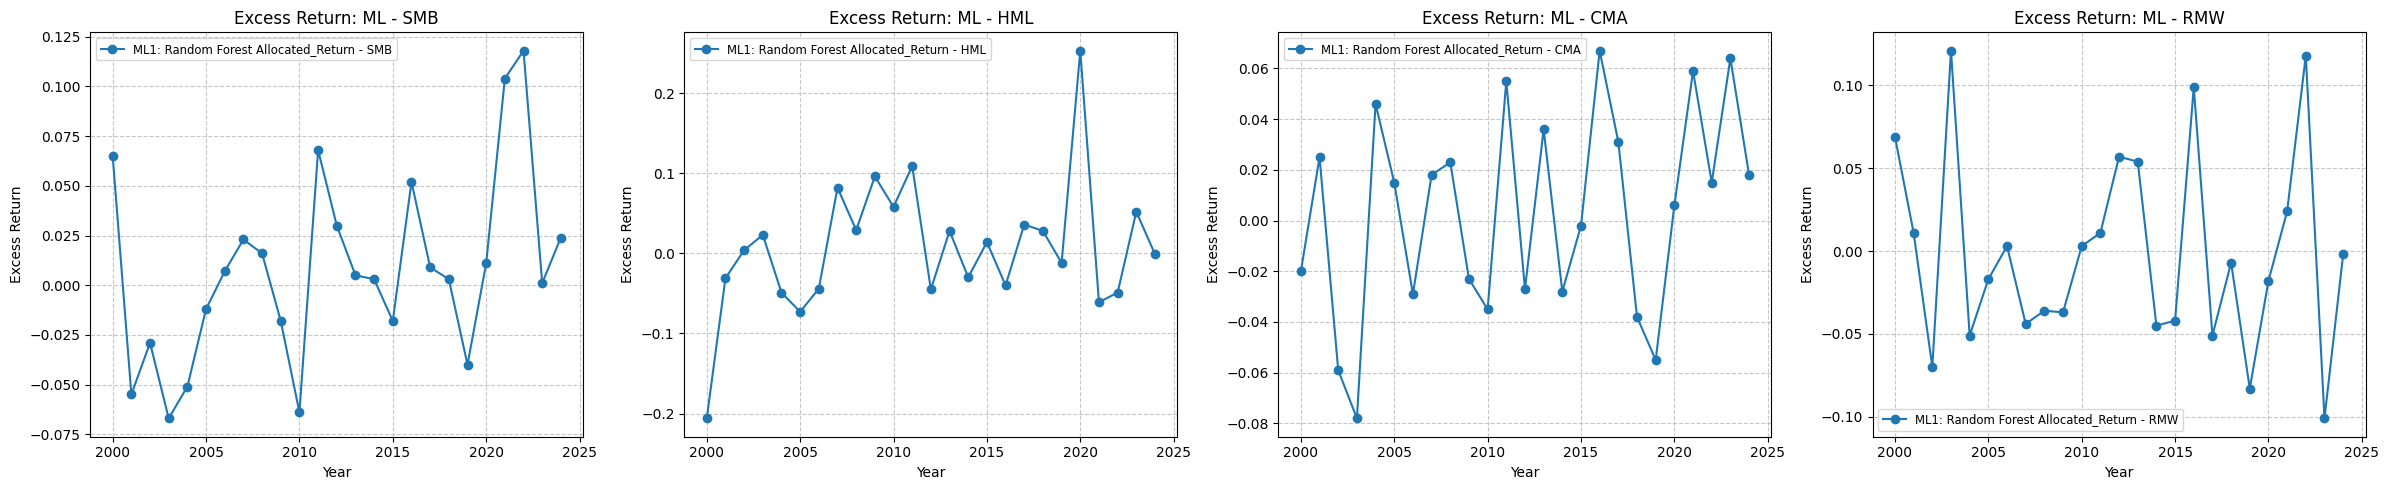


Annual Returns - Equal Weight Strategy:


,Equal_Weight_Return
Year,
2000,0.098
2001,0.091
2002,-0.156
2003,0.469
2004,0.174
2005,0.067
2006,0.193
2007,-0.018
2008,-0.342


In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# ============================================================================
# 1) Prepare Annual Return Data
# ============================================================================

# Define the date range for annual analysis.
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame (combined_df) for the desired date range.
# (combined_df comes from your earlier multi‑model merging steps.)
df_annual = combined_df[(combined_df['Predicted_month'] >= start_date) &
                          (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column.
df_annual['Year'] = df_annual['Predicted_month'].dt.year

# ---------------------------------------------------------------------
# Identify columns:
#   • ML strategy columns: they contain "Allocated_Return" (e.g., "ML1: Random Forest Allocated_Return")
#   • Benchmark: assume the column is "Benchmark Return" (or use what was defined earlier).
#   • Equal Weight: assume "Equal_Weight_Return"
#   • Factor columns: using the global FACTORS (e.g., ['SMB', 'HML', 'CMA', 'RMW'])
# ---------------------------------------------------------------------
ml_cols = [col for col in df_annual.columns if ("Allocated_Return" in col) and ("Cumulative" not in col)]
benchmark_col = "Benchmark Return" if "Benchmark Return" in df_annual.columns else None
equal_weight_col = "Equal_Weight_Return" if "Equal_Weight_Return" in df_annual.columns else None
factor_cols = [fac for fac in FACTORS if fac in df_annual.columns]

print("ML Strategy Columns:", ml_cols)
print("Benchmark Column:", benchmark_col)
print("Equal Weight Column:", equal_weight_col)
print("Factor Columns:", factor_cols)

# ---------------------------------------------------------------------
# Function to compute annual return as the compounded return over the year.
# ---------------------------------------------------------------------
def annual_return(group, col):
    """Compound return over the group: product(1 + r) - 1."""
    return (1 + group[col]).prod() - 1

# ---------------------------------------------------------------------
# Compute annual returns for each strategy.
# We'll build a dictionary where keys are strategy names and values are Series indexed by Year.
annual_returns = {}

# For each ML model column.
for col in ml_cols:
    annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))

# For benchmark.
if benchmark_col is not None:
    annual_returns[benchmark_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, benchmark_col))

# For equal weight strategy.
if equal_weight_col is not None:
    annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))

# For each factor.
for fac in factor_cols:
    annual_returns[fac] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, fac))

# Combine the computed annual returns into one DataFrame.
annual_returns_df = pd.DataFrame(annual_returns)
annual_returns_df = annual_returns_df.round(3)

# Display the Annual Returns Table.
display(HTML("<h3>Annual Returns Table</h3>" + annual_returns_df.to_html()))

# ============================================================================
# 2) Compute Excess Returns and Plot by Factor
# ============================================================================

# For each factor, compute excess return for each ML model relative to that factor.
# We define excess return as: (ML Annual Return) - (Factor Annual Return)
excess_returns = {}
for fac in factor_cols:
    # Create a DataFrame of excess returns for all ML models for factor 'fac'
    excess_df = pd.DataFrame()
    for ml in ml_cols:
        excess_df[ml] = annual_returns_df[ml] - annual_returns_df[fac]
    excess_returns[fac] = excess_df

# Now plot excess returns by factor.
n_factors = len(factor_cols)
if n_factors > 0:
    # Create one subplot per factor.
    fig, axes = plt.subplots(1, n_factors, figsize=(6 * n_factors, 5), sharex=True)
    if n_factors == 1:
        axes = [axes]
    for i, fac in enumerate(factor_cols):
        ax = axes[i]
        # Plot a line for each ML model excess return for this factor.
        for ml in ml_cols:
            ax.plot(excess_returns[fac].index, excess_returns[fac][ml],
                    marker='o', label=f'{ml} - {fac}')
        ax.set_title(f'Excess Return: ML - {fac}')
        ax.set_xlabel("Year")
        ax.set_ylabel("Excess Return")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# ============================================================================
# 3) (Optional) Compute and Plot Annual Returns for Benchmark and Equal Weight
# ============================================================================

# For convenience, let's display the annual returns for benchmark and equal weight strategies.
if benchmark_col is not None:
    print("\nAnnual Returns - Benchmark:")
    display(annual_returns_df[[benchmark_col]])
if equal_weight_col is not None:
    print("\nAnnual Returns - Equal Weight Strategy:")
    display(annual_returns_df[[equal_weight_col]])


##Return comparison by period

In [438]:
import pandas as pd
import numpy as np
from IPython.display import display

# -------------------------------------------------
# 1) Create a "Year" Column in the Merged DataFrame
# -------------------------------------------------
combined_df['Year'] = pd.to_datetime(combined_df['Predicted_month']).dt.year

# -------------------------------------------------
# 2) Define a Function to Calculate Annual Return
# -------------------------------------------------
def annual_return(series):
    """
    Compute the annual compounded return from a monthly return series.
    """
    return (1 + series).prod() - 1

# -------------------------------------------------
# 3) Compute Annual Returns for Each Strategy:
#    a) For each ML model's allocated return.
#    b) For Benchmark Return.
#    c) For Equal Weight Return.
# -------------------------------------------------
# a) For ML models: we assume these columns start with "ML" and contain "Allocated_Return"
ml_cols = [col for col in combined_df.columns
           if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]
annual_returns_ml = {col: combined_df.groupby("Year")[col].apply(annual_return) for col in ml_cols}

# b) For Benchmark:
annual_return_bench = None
if "Benchmark Return" in combined_df.columns:
    annual_return_bench = combined_df.groupby("Year")["Benchmark Return"].apply(annual_return)

# c) For Equal Weight:
annual_return_eq = None
if "Equal_Weight_Return" in combined_df.columns:
    annual_return_eq = combined_df.groupby("Year")["Equal_Weight_Return"].apply(annual_return)

# -------------------------------------------------
# 4) Compute Annual Returns for Each Factor in FACTORS:
# -------------------------------------------------
annual_returns_factors = {}
for factor in FACTORS:
    if factor in combined_df.columns:
        annual_returns_factors[factor] = combined_df.groupby("Year")[factor].apply(annual_return)

# -------------------------------------------------
# 5) Compute Excess Returns for each ML model relative to each factor.
#    Excess = (ML Model Annual Return) - (Factor Annual Return)
# -------------------------------------------------
excess_returns = {}
for ml_col, ml_series in annual_returns_ml.items():
    df_excess = pd.DataFrame(index=ml_series.index)
    for factor, factor_series in annual_returns_factors.items():
        df_excess[f"Excess ({ml_col} - {factor})"] = ml_series - factor_series
    excess_returns[ml_col] = df_excess

# -------------------------------------------------
# 6) Build a Summary Table of Annual Returns for all Strategies
# -------------------------------------------------
years = sorted(combined_df['Year'].unique())
annual_summary = pd.DataFrame(index=years)

# Add ML model returns.
for ml_col, series in annual_returns_ml.items():
    annual_summary[ml_col] = series

# Add benchmark return if available.
if annual_return_bench is not None:
    annual_summary["Benchmark Return"] = annual_return_bench

# Add equal weight return if available.
if annual_return_eq is not None:
    annual_summary["Equal_Weight_Return"] = annual_return_eq

# -------------------------------------------------
# 7) Display the Summary Table and (optionally) Excess Returns for the First ML Model
# -------------------------------------------------
print("Annual Returns Summary:")
display(annual_summary.round(3))

# Optionally, display excess returns for the first ML model.
first_ml_col = ml_cols[0] if ml_cols else None
if first_ml_col is not None:
    print(f"\nExcess Returns for {first_ml_col}:")
    display(excess_returns[first_ml_col].round(3))


Annual Returns Summary:


,ML1: Random Forest Allocated_Return,Equal_Weight_Return
1968,0.157,0.137
1969,-0.187,-0.189
1970,0.029,-0.004
1971,0.230,0.196
1972,0.162,0.097
1973,-0.221,-0.271
1974,-0.191,-0.227
1975,0.523,0.544
1976,0.486,0.434
1977,0.150,0.108



Excess Returns for ML1: Random Forest Allocated_Return:


,Excess (ML1: Random Forest Allocated_Return - SMB),Excess (ML1: Random Forest Allocated_Return - HML),Excess (ML1: Random Forest Allocated_Return - CMA),Excess (ML1: Random Forest Allocated_Return - RMW)
Year,,,,
1968,-0.004,-0.007,0.005,0.084
1969,0.048,0.022,0.009,-0.075
1970,0.130,-0.058,-0.047,0.098
1971,0.003,0.086,0.060,-0.012
1972,0.121,0.038,0.085,0.017
1973,0.146,-0.056,0.018,0.081
1974,0.073,0.017,-0.064,0.112
1975,-0.075,-0.052,0.024,0.023
1976,0.016,-0.036,0.077,0.147


# Corr Heat map & regiimi sharpet


          SMB       HML       CMA       RMW
SMB  1.000000  0.926047  0.961249  0.948092
HML  0.926047  1.000000  0.948635  0.912713
CMA  0.961249  0.948635  1.000000  0.945924
RMW  0.948092  0.912713  0.945924  1.000000


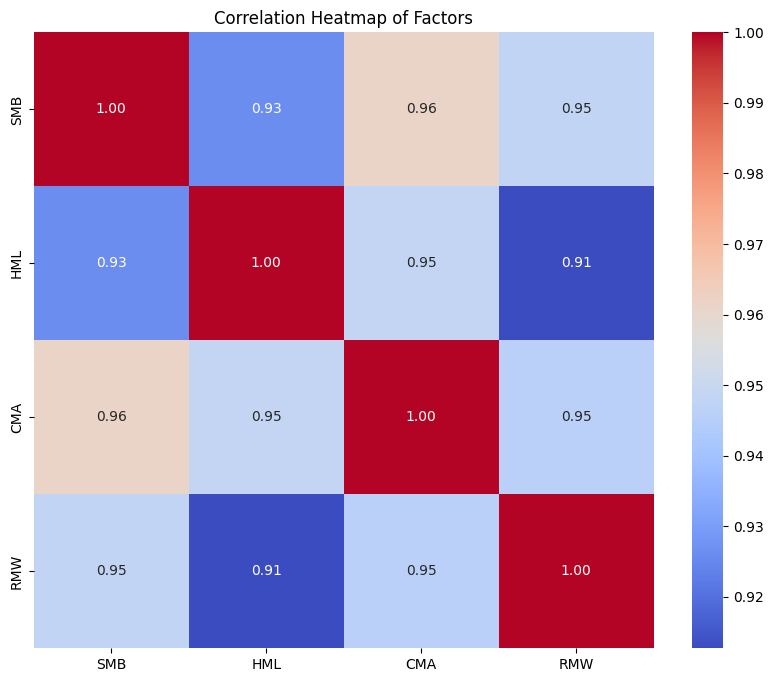

In [439]:
import seaborn as sns
import matplotlib.pyplot as plt

df = xls_file.parse(SHEET_NAME)
df = df[["Date"] + FACTORS]

# Calculate correlations
correlation_matrix = df[FACTORS].corr()

# Show regular correlation table
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Factors")
plt.show()


In [440]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



KeyError: 'Predicted_reg'

In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##Feature importance by period

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()